# Producing and discriminating synthetic user profiles

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.init as init

from simple_nn_model import SimpleNN
import pandas as pd

In [2]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, TVAESynthesizer, CopulaGANSynthesizer
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### load data

In [4]:
feature_matrix_nona_nostr = pd.read_csv("dataset/feature_matrix_nona_nostr.tdt", sep='\t')
feature_matrix_nona_nostr

user_id   O   C   E   A   N  AVERAGE_COUNT_PER_UNIQUE(logons.activity)  \
0    CEL0561  40  39  36  19  40                                      480.5   
1    CRD0624  26  22  17  39  32                                       50.0   
2    JFC0557  22  16  23  40  33                                      480.5   
3    ASD0577  40  48  36  14  37                                      346.0   
4    MAR0955  36  44  23  44  25                                      302.0   
..       ...  ..  ..  ..  ..  ..                                        ...   
995  DTT0076  42  16  34  24  28                                      346.0   
996  PRM0740  45  40  45  42  27                                      346.0   
997  FGW0853  25  35  20  40  39                                      455.0   
998  JSH0330  20  16  23  24  28                                      346.0   
999  FSB0399  23  22  15  37  26                                      335.0   

     AVERAGE_COUNT_PER_UNIQUE(logons.pc)  COUNT(logons)  \
0                               0.958126            961   
1                               0.099701            100   
2                               0.958126            961   
3                               0.689930            692   
4                               0.602193            604   
..                                   ...            ...   
995                             0.689930            692   
996                             0.689930            692   
997                             0.907278            910   
998                             0.689930            692   
999                             0.667996            670   

     ENTROPY(logons.activity)  ...  WEEKDAY(LAST(emails.date))  \
0                    0.653442  ...                           0   
1                    0.693147  ...                           4   
2                    0.653442  ...                           0   
3                    0.693147  ...                           0   
4                    0.693147  ...                           4   
..                        ...  ...                         ...   
995                  0.693147  ...                           0   
996                  0.693147  ...                           0   
997                  0.693147  ...                           0   
998                  0.693147  ...                           0   
999                  0.693147  ...                           4   

     WEEKDAY(LAST(https.date))  WEEKDAY(LAST(logons.date))  \
0                            0                           0   
1                            4                           4   
2                            0                           0   
3                            0                           0   
4                            4                           4   
..                         ...                         ...   
995                          0                           0   
996                          0                           0   
997                          0                           0   
998                          0                           0   
999                          4                           4   

     YEAR(FIRST(emails.date))  YEAR(FIRST(https.date))  \
0                        2010                     2010   
1                        2010                     2010   
2                        2010                     2010   
3                        2010                     2010   
4                        2010                     2010   
..                        ...                      ...   
995                      2010                     2010   
996                      2010                     2010   
997                      2010                     2010   
998                      2010                     2010   
999                      2010                     2010   

     YEAR(FIRST(logons.date))  YEAR(LAST(emails.date))  \
0                        2010                     2011

In [5]:
feature_matrix_nona_nostr.columns = [col.replace('email', 'XXXXX') for col in feature_matrix_nona_nostr.columns]
feature_matrix_nona_nostr

user_id   O   C   E   A   N  AVERAGE_COUNT_PER_UNIQUE(logons.activity)  \
0    CEL0561  40  39  36  19  40                                      480.5   
1    CRD0624  26  22  17  39  32                                       50.0   
2    JFC0557  22  16  23  40  33                                      480.5   
3    ASD0577  40  48  36  14  37                                      346.0   
4    MAR0955  36  44  23  44  25                                      302.0   
..       ...  ..  ..  ..  ..  ..                                        ...   
995  DTT0076  42  16  34  24  28                                      346.0   
996  PRM0740  45  40  45  42  27                                      346.0   
997  FGW0853  25  35  20  40  39                                      455.0   
998  JSH0330  20  16  23  24  28                                      346.0   
999  FSB0399  23  22  15  37  26                                      335.0   

     AVERAGE_COUNT_PER_UNIQUE(logons.pc)  COUNT(logons)  \
0                               0.958126            961   
1                               0.099701            100   
2                               0.958126            961   
3                               0.689930            692   
4                               0.602193            604   
..                                   ...            ...   
995                             0.689930            692   
996                             0.689930            692   
997                             0.907278            910   
998                             0.689930            692   
999                             0.667996            670   

     ENTROPY(logons.activity)  ...  WEEKDAY(LAST(XXXXXs.date))  \
0                    0.653442  ...                           0   
1                    0.693147  ...                           4   
2                    0.653442  ...                           0   
3                    0.693147  ...                           0   
4                    0.693147  ...                           4   
..                        ...  ...                         ...   
995                  0.693147  ...                           0   
996                  0.693147  ...                           0   
997                  0.693147  ...                           0   
998                  0.693147  ...                           0   
999                  0.693147  ...                           4   

     WEEKDAY(LAST(https.date))  WEEKDAY(LAST(logons.date))  \
0                            0                           0   
1                            4                           4   
2                            0                           0   
3                            0                           0   
4                            4                           4   
..                         ...                         ...   
995                          0                           0   
996                          0                           0   
997                          0                           0   
998                          0                           0   
999                          4                           4   

     YEAR(FIRST(XXXXXs.date))  YEAR(FIRST(https.date))  \
0                        2010                     2010   
1                        2010                     2010   
2                        2010                     2010   
3                        2010                     2010   
4                        2010                     2010   
..                        ...                      ...   
995                      2010                     2010   
996                      2010                     2010   
997                      2010                     2010   
998                      2010                     2010   
999                      2010                     2010   

     YEAR(FIRST(logons.date))  YEAR(LAST(XXXXXs.date))  \
0                        2010                     2011

In [6]:
feature_matrix_nona_nostr.dtypes

user_id                     object
O                            int64
C                            int64
E                            int64
A                            int64
                             ...  
YEAR(FIRST(logons.date))     int64
YEAR(LAST(XXXXXs.date))      int64
YEAR(LAST(https.date))       int64
YEAR(LAST(logons.date))      int64
label                        int64
Length: 432, dtype: object

# creating schema of extracted features table

In [7]:
metadata = SingleTableMetadata()

In [8]:
metadata

{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [9]:
metadata.detect_from_dataframe(feature_matrix_nona_nostr)
metadata

{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "user_id": {
            "sdtype": "id"
        },
        "O": {
            "sdtype": "numerical"
        },
        "C": {
            "sdtype": "numerical"
        },
        "E": {
            "sdtype": "numerical"
        },
        "A": {
            "sdtype": "numerical"
        },
        "N": {
            "sdtype": "numerical"
        },
        "AVERAGE_COUNT_PER_UNIQUE(logons.activity)": {
            "sdtype": "numerical"
        },
        "AVERAGE_COUNT_PER_UNIQUE(logons.pc)": {
            "sdtype": "numerical"
        },
        "COUNT(logons)": {
            "sdtype": "numerical"
        },
        "ENTROPY(logons.activity)": {
            "sdtype": "numerical"
        },
        "ENTROPY(logons.pc)": {
            "sdtype": "numerical"
        },
        "NUM_UNIQUE(logons.activity)": {
            "sdtype": "categorical"
        },
        "NUM_UNIQUE(logons.pc)": {
            "sdtype": "nu

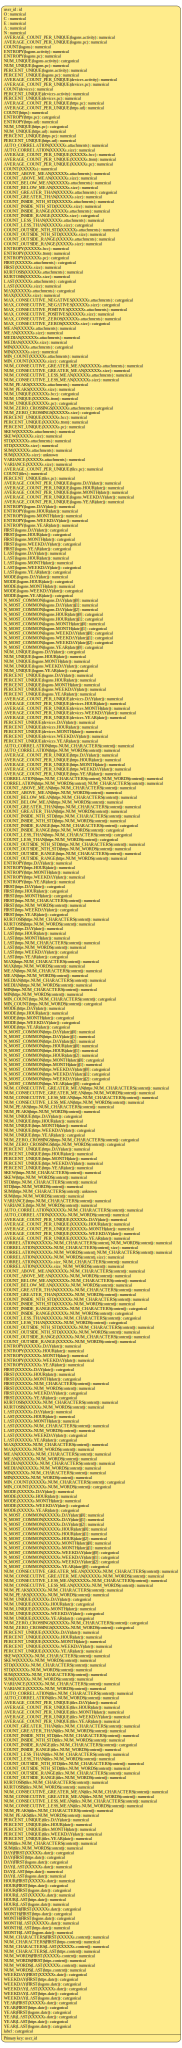

In [10]:
metadata.visualize()

In [11]:
metadata.update_column(
    column_name='SUM(https.NUM_CHARACTERS(content))',
    sdtype='numerical')
metadata.update_column(
    column_name='SUM(XXXXXs.size)',
    sdtype='numerical')

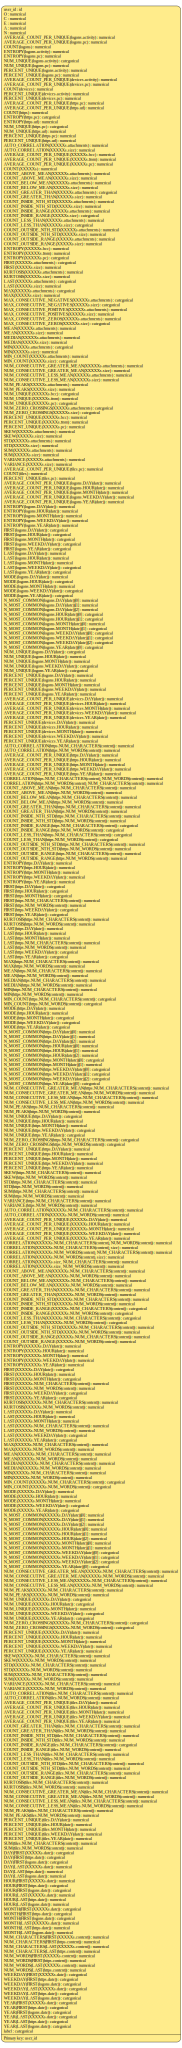

In [12]:
metadata.visualize()

### define hyperparameters

In [13]:
batch_size = 16
input_size = feature_matrix_nona_nostr.shape[1]-2  # Adjust based on the number of features in your tabular data
target_lr = 0.001
warmup_epochs = 5
num_epochs = 10000

### function to evaluate the model on disciminating real and synthetic users

In [14]:
def run_discriminator_training(generated_data):
    real_data = np.array(feature_matrix_nona_nostr.iloc[:, 1:], dtype=np.float32)
    syn_data = np.array(generated_data.iloc[:, 1:], dtype=np.float32)

    # Combine real and synthetic data
    real_labels = np.zeros((len(real_data), 1), dtype=np.float32)
    syn_labels = np.ones((len(syn_data), 1), dtype=np.float32)

    real_data_with_labels = np.concatenate((real_data, real_labels), axis=1)
    syn_data_with_labels = np.concatenate((syn_data, syn_labels), axis=1)

    # Combine and shuffle the data
    all_data = np.concatenate((real_data_with_labels, syn_data_with_labels), axis=0)
    np.random.shuffle(all_data)

    # Separate features and labels
    features = all_data[:, :-2]
    labels = all_data[:, -1:]
    multi_labels = all_data[:, -2:-1]

    # Split the data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp, z_train, z_temp = train_test_split(features, labels, multi_labels, test_size=0.3, stratify=multi_labels, random_state=42)
    X_val, X_test, y_val, y_test, z_val, z_test = train_test_split(X_temp, y_temp, z_temp, test_size=0.66, stratify=z_temp, random_state=42)

    # Feature scaling using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train)
    z_train_tensor = torch.FloatTensor(z_train)

    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.FloatTensor(y_val)
    z_val_tensor = torch.FloatTensor(z_val)

    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test)
    z_test_tensor = torch.FloatTensor(z_test)

    # Create TensorDatasets and DataLoaders for training, validation, and test
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor, z_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor, z_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor, z_test_tensor)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    train_loader2 = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Create model
    model = SimpleNN(input_size).to(device)

    # Define loss functions and optimizers
    criterion = nn.BCELoss()

    # Exponentially decreasing learning rate
    optimizer = optim.Adam(model.parameters(), lr=target_lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)

    # Learning rate warm-up
    warmup_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: (epoch + 1) / warmup_epochs)

    # Early stopping parameters
    early_stopping_patience = 20
    early_stopping_counter = 0
    best_val_loss = float('inf')

    # Lists to store training and validation losses and accuracies
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    epochs = []

    # Training loop
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        total_correct_train = 0
        total_samples_train = 0
        running_loss = 0.0

        # Training
        model.train()
        for i, (real_batch, labels, __) in enumerate(train_loader):
            # Forward pass
            outputs = model(real_batch)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predictions = (outputs > 0.5).float()
            total_correct_train += (predictions == labels).sum().item()
            total_samples_train += labels.size(0)
            running_loss += loss.item()

        # Average training loss
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * total_correct_train / total_samples_train

        # Validation
        model.eval()
        val_running_loss = 0.0
        total_correct_val = 0
        total_samples_val = 0
        with torch.no_grad():
            for val_features, val_labels, __ in val_loader:
                val_outputs = model(val_features)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                # Calculate validation accuracy
                val_predictions = (val_outputs > 0.5).float()
                total_correct_val += (val_predictions == val_labels).sum().item()
                total_samples_val += val_labels.size(0)

        # Average validation loss
        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * total_correct_val / total_samples_val

        # Log training and validation statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], Avg. Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}%, Avg. Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}%')

        # Append losses and accuracies to lists
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        epochs.append(epoch)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping due to no improvement in validation loss.")
                break

        # Adjust learning rate based on validation loss
        if epoch+1 < warmup_epochs:
            warmup_scheduler.step()  # Use warm-up scheduler
        else:
            scheduler.step(avg_val_loss)  # Use regular scheduler



    # Plotting the curves
    skp_itrs = 5
    plt.figure(figsize=(12, 4))

    # Plotting loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs[skp_itrs:], train_losses[skp_itrs:], label='Training Loss')
    plt.plot(epochs[skp_itrs:], val_losses[skp_itrs:], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # Test the model
    model.eval()
    with torch.no_grad():
        correct_all = 0
        total_all = 0
        correct_0 = 0
        total_0 = 0
        correct_1 = 0
        total_1 = 0
        correct_2 = 0
        total_2 = 0
        correct_3 = 0
        total_3 = 0
        correct_abn = 0
        total_abn = 0
        for images, labels, __ in test_loader:
            outputs = model(images)

            predictions = (outputs > 0.5).float()  # Binary thresholding for predictions
            total_all += labels.size(0)
            correct_all += (predictions == labels.float().view(-1, 1)).sum().item()
            
            total_0 += (0 == __.float().view(-1, 1)).sum().item()
            correct_0 += ((__ == 0) & (predictions == labels.float().view(-1, 1))).sum().item()
            total_1 += (1 == __.float().view(-1, 1)).sum().item()
            correct_1 += ((__ == 1) & (predictions == labels.float().view(-1, 1))).sum().item()
            total_2 += (2 == __.float().view(-1, 1)).sum().item()
            correct_2 += ((__ == 2) & (predictions == labels.float().view(-1, 1))).sum().item()
            total_3 += (3 == __.float().view(-1, 1)).sum().item()
            correct_3 += ((__ == 3) & (predictions == labels.float().view(-1, 1))).sum().item()
            total_abn += (0 < __.float().view(-1, 1)).sum().item()
            correct_abn += ((__ > 0) & (predictions == labels.float().view(-1, 1))).sum().item()

        print('Accuracy of the network on the test set: {} %'.format(100 * correct_all / total_all))

        return 100 * correct_all / total_all, 100 * correct_0 / total_0, 100 * correct_1 / total_1, 100 * correct_2 / total_2, 100 * correct_3 / total_3, 100 * correct_abn / total_abn

### producing synthetic user profiles using:
### 1. classical ML (Gaussian Copula)

##################################### Iteration  1 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 538.84it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [15:21<00:00, 100.97it/s]

Overall Score: 79.9%

Properties:
- Column Shapes: 76.13%
- Column Pair Trends: 83.67%
Epoch [1/10000], Avg. Training Loss: 0.7567526532167738, Training Accuracy: 55.92857142857143%, Avg. Validation Loss: 0.5694566919253423, Validation Accuracy: 70.58823529411765%
Epoch [2/10000], Avg. Training Loss: 0.4742131602357734, Training Accuracy: 77.57142857142857%, Avg. Validat

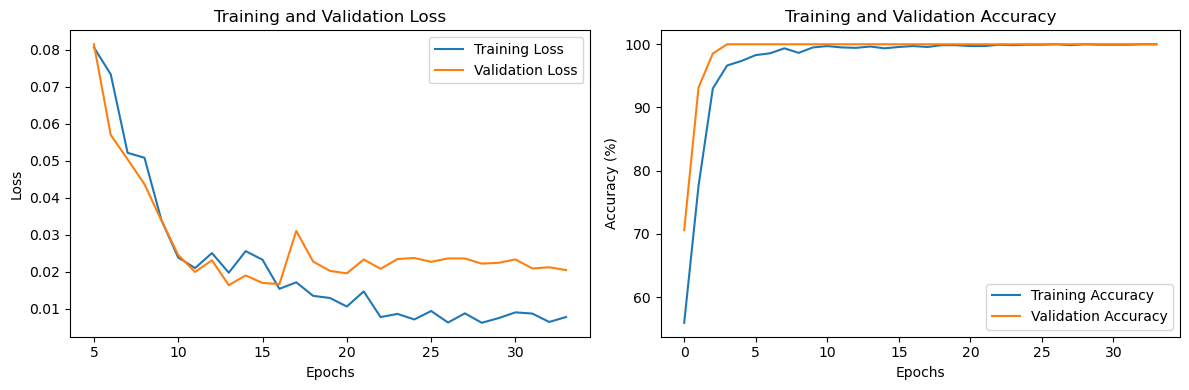

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  2 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 395.13it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [15:07<00:00, 102.60it/s]

Overall Score: 79.9%

Properties:
- Column Shapes: 76.13%
- Column Pair Trends: 83.67%
Epoch [1/10000], Avg. Training Loss: 0.6266917108812116, Training Accuracy: 64.5%, Avg. Validation Loss: 0.5131800037163955, Validation Accuracy: 78.43137254901961%
Epoch [2/10000], Avg. Training Loss: 0.35901589098979125, Training Accur

Epoch [42/10000], Avg. Training Loss: 0.0035127096648052843, Training Accuracy: 100.0%, Avg. Validation Loss: 0.008833343485513559, Validation Accuracy: 100.0%
Epoch [43/10000], Avg. Training Loss: 0.004399952827952802, Training Accuracy: 100.0%, Avg. Validation Loss: 0.009408101654396607, Validation Accuracy: 100.0%
Epoch [44/10000], Avg. Training Loss: 0.0034694212835430253, Training Accuracy: 100.0%, Avg. Validation Loss: 0.010001192442499675, Validation Accuracy: 100.0%
Epoch [45/10000], Avg. Training Loss: 0.004136334219682877, Training Accuracy: 100.0%, Avg. Validation Loss: 0.01063413262510529, Validation Accuracy: 100.0%
Epoch [46/10000], Avg. Training Loss: 0.0040036798150553795, Training Accuracy: 100.0%, Avg. Validation Loss: 0.009377682402443428, Validation Accuracy: 100.0%
Epoch [47/10000], Avg. Training Loss: 0.01102298779534811, Training Accuracy: 99.78571428571429%, Avg. Validation Loss: 0.008292888935941916, Validation Accuracy: 100.0%
Epoch [48/10000], Avg. Training L

Epoch [93/10000], Avg. Training Loss: 0.004799231586565094, Training Accuracy: 100.0%, Avg. Validation Loss: 0.010591491447904935, Validation Accuracy: 100.0%
Epoch [94/10000], Avg. Training Loss: 0.004598337682016956, Training Accuracy: 100.0%, Avg. Validation Loss: 0.00976849515707447, Validation Accuracy: 100.0%
Epoch [95/10000], Avg. Training Loss: 0.0039111058735712, Training Accuracy: 100.0%, Avg. Validation Loss: 0.008673631836875128, Validation Accuracy: 100.0%
Epoch [96/10000], Avg. Training Loss: 0.004003055891106752, Training Accuracy: 100.0%, Avg. Validation Loss: 0.008506591575076947, Validation Accuracy: 100.0%
Epoch [97/10000], Avg. Training Loss: 0.0033431185676652767, Training Accuracy: 100.0%, Avg. Validation Loss: 0.008206179795356898, Validation Accuracy: 100.0%
Epoch [98/10000], Avg. Training Loss: 0.0034977784208339554, Training Accuracy: 100.0%, Avg. Validation Loss: 0.009326680276829463, Validation Accuracy: 100.0%
Epoch [99/10000], Avg. Training Loss: 0.0041347

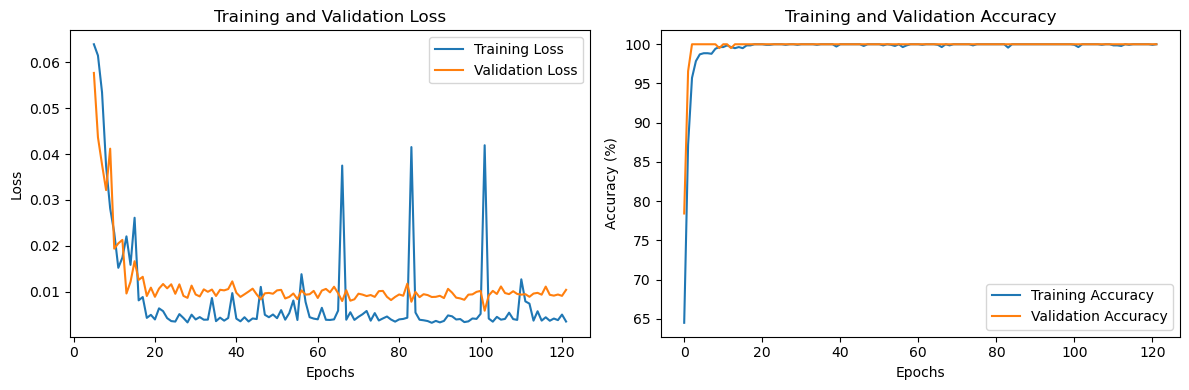

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  3 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 667.78it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [16:15<00:00, 95.47it/s]

Overall Score: 79.9%

Properties:
- Column Shapes: 76.13%
- Column Pair Trends: 83.67%
Epoch [1/10000], Avg. Training Loss: 0.6133802282539281, Training Accuracy: 65.64285714285714%, Avg. Validation Loss: 0.4672586230131296, Validation Accuracy: 88.72549019607843%
Epoch [2/10000], Avg. Training Loss: 0.35484024408188736, T

Epoch [43/10000], Avg. Training Loss: 0.015028903854148335, Training Accuracy: 99.5%, Avg. Validation Loss: 0.011201488857085887, Validation Accuracy: 100.0%
Epoch [44/10000], Avg. Training Loss: 0.0026412654353242197, Training Accuracy: 100.0%, Avg. Validation Loss: 0.00866244575725152, Validation Accuracy: 100.0%
Epoch [45/10000], Avg. Training Loss: 0.008967068808322603, Training Accuracy: 99.85714285714286%, Avg. Validation Loss: 0.009094064911970725, Validation Accuracy: 100.0%
Epoch [46/10000], Avg. Training Loss: 0.003485454148176359, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.007164315213091099, Validation Accuracy: 100.0%
Epoch 00042: reducing learning rate of group 0 to 1.0000e-05.
Epoch [47/10000], Avg. Training Loss: 0.0026269033485071054, Training Accuracy: 100.0%, Avg. Validation Loss: 0.007102214516355441, Validation Accuracy: 100.0%
Epoch [48/10000], Avg. Training Loss: 0.0020529297301188558, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0075165

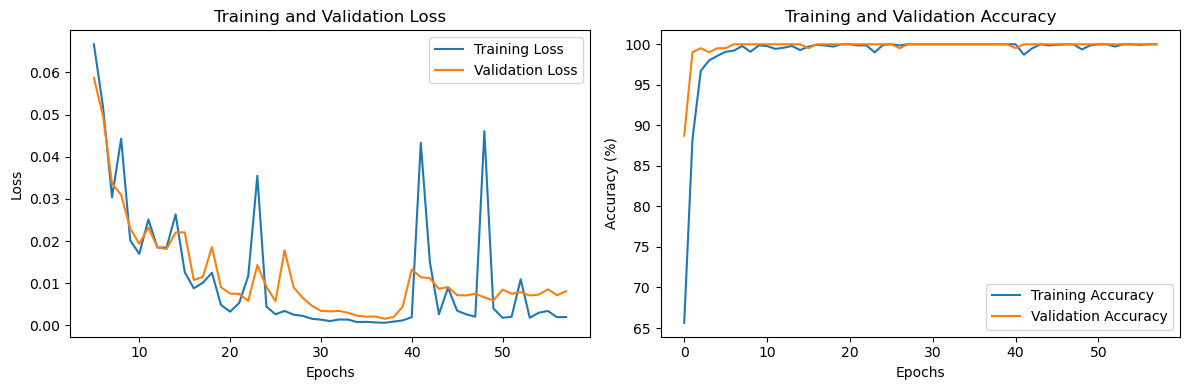

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  4 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 389.48it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [17:22<00:00, 89.26it/s]

Overall Score: 79.9%

Properties:
- Column Shapes: 76.13%
- Column Pair Trends: 83.67%
Epoch [1/10000], Avg. Training Loss: 0.6748818132010374, Training Accuracy: 60.857142857142854%, Avg. Validation Loss: 0.5029732791277078, Validation Accuracy: 78.43137254901961%
Epoch [2/10000], Avg. Training Loss: 0.36736877025528386, 

Epoch [42/10000], Avg. Training Loss: 0.0025059633437856314, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0059523433446884155, Validation Accuracy: 100.0%
Epoch [43/10000], Avg. Training Loss: 0.002221110892027024, Training Accuracy: 100.0%, Avg. Validation Loss: 0.007075406503505432, Validation Accuracy: 100.0%
Epoch 00039: reducing learning rate of group 0 to 1.0000e-06.
Epoch [44/10000], Avg. Training Loss: 0.0030415180934307336, Training Accuracy: 100.0%, Avg. Validation Loss: 0.007529851228285294, Validation Accuracy: 100.0%
Epoch [45/10000], Avg. Training Loss: 0.0029542973550798542, Training Accuracy: 100.0%, Avg. Validation Loss: 0.006117700778234463, Validation Accuracy: 100.0%
Epoch [46/10000], Avg. Training Loss: 0.0031913763480340344, Training Accuracy: 100.0%, Avg. Validation Loss: 0.006793535887621916, Validation Accuracy: 100.0%
Epoch [47/10000], Avg. Training Loss: 0.005435272721859457, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.007490092566093

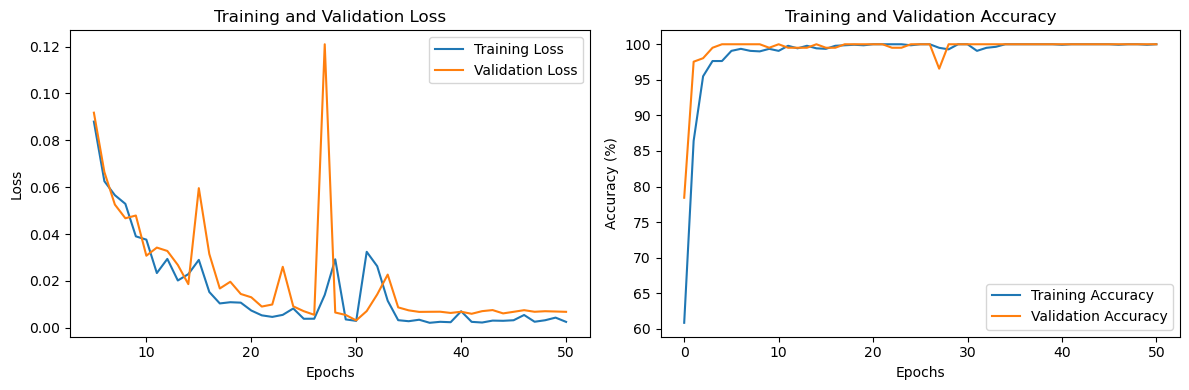

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  5 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 482.05it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [21:23<00:00, 72.52it/s]

Overall Score: 79.9%

Properties:
- Column Shapes: 76.13%
- Column Pair Trends: 83.67%
Epoch [1/10000], Avg. Training Loss: 0.6435173441740599, Training Accuracy: 62.285714285714285%, Avg. Validation Loss: 0.5606772303581238, Validation Accuracy: 78.92156862745098%
Epoch [2/10000], Avg. Training Loss: 0.35907570137218997, 

Epoch [42/10000], Avg. Training Loss: 0.04848874584687027, Training Accuracy: 99.64285714285714%, Avg. Validation Loss: 0.003754121197674137, Validation Accuracy: 100.0%
Epoch [43/10000], Avg. Training Loss: 0.0012925397862669672, Training Accuracy: 100.0%, Avg. Validation Loss: 0.004410194752451319, Validation Accuracy: 100.0%
Epoch 00039: reducing learning rate of group 0 to 1.0000e-06.
Epoch [44/10000], Avg. Training Loss: 0.001213523584738141, Training Accuracy: 100.0%, Avg. Validation Loss: 0.004246436363945787, Validation Accuracy: 100.0%
Epoch [45/10000], Avg. Training Loss: 0.0014951645290156275, Training Accuracy: 100.0%, Avg. Validation Loss: 0.004865346064504523, Validation Accuracy: 100.0%
Epoch [46/10000], Avg. Training Loss: 0.0013253958446016027, Training Accuracy: 100.0%, Avg. Validation Loss: 0.004443925268088396, Validation Accuracy: 100.0%
Epoch [47/10000], Avg. Training Loss: 0.000866496740028114, Training Accuracy: 100.0%, Avg. Validation Loss: 0.004370098700746894

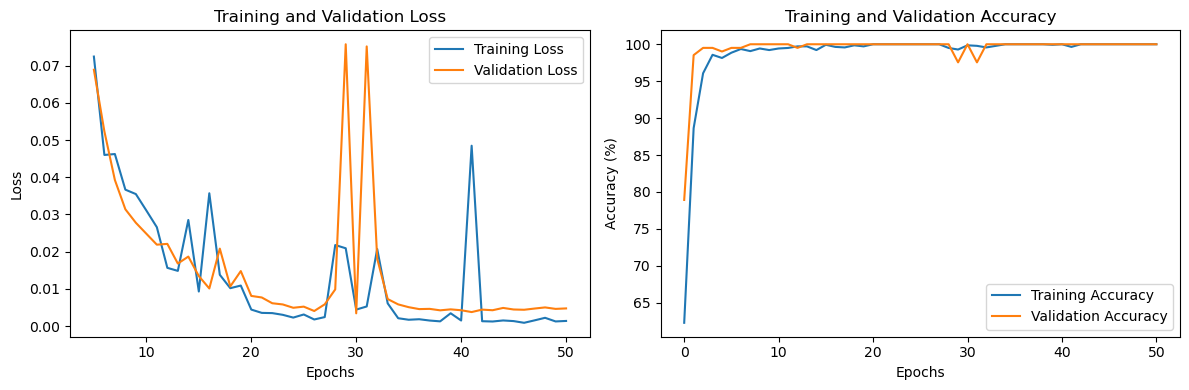

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  6 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 608.13it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [16:24<00:00, 94.51it/s]

Overall Score: 79.9%

Properties:
- Column Shapes: 76.13%
- Column Pair Trends: 83.67%
Epoch [1/10000], Avg. Training Loss: 0.6668477214195512, Training Accuracy: 61.5%, Avg. Validation Loss: 0.5052997263578268, Validation Accuracy: 82.3529411764706%
Epoch [2/10000], Avg. Training Loss: 0.38361751051111653, Training Accura

Epoch [43/10000], Avg. Training Loss: 0.002134204101325436, Training Accuracy: 100.0%, Avg. Validation Loss: 0.004754995157082493, Validation Accuracy: 100.0%
Epoch [44/10000], Avg. Training Loss: 0.0025335942125159568, Training Accuracy: 100.0%, Avg. Validation Loss: 0.005280908555365526, Validation Accuracy: 100.0%
Epoch [45/10000], Avg. Training Loss: 0.0022181816741728903, Training Accuracy: 100.0%, Avg. Validation Loss: 0.005314353387802839, Validation Accuracy: 100.0%
Epoch 00041: reducing learning rate of group 0 to 1.0000e-06.
Epoch [46/10000], Avg. Training Loss: 0.0026360237173900136, Training Accuracy: 100.0%, Avg. Validation Loss: 0.005523139575066475, Validation Accuracy: 100.0%
Epoch [47/10000], Avg. Training Loss: 0.002177935641983905, Training Accuracy: 100.0%, Avg. Validation Loss: 0.005323776151411808, Validation Accuracy: 100.0%
Epoch [48/10000], Avg. Training Loss: 0.002594788569364358, Training Accuracy: 100.0%, Avg. Validation Loss: 0.005675847946594541, Validatio

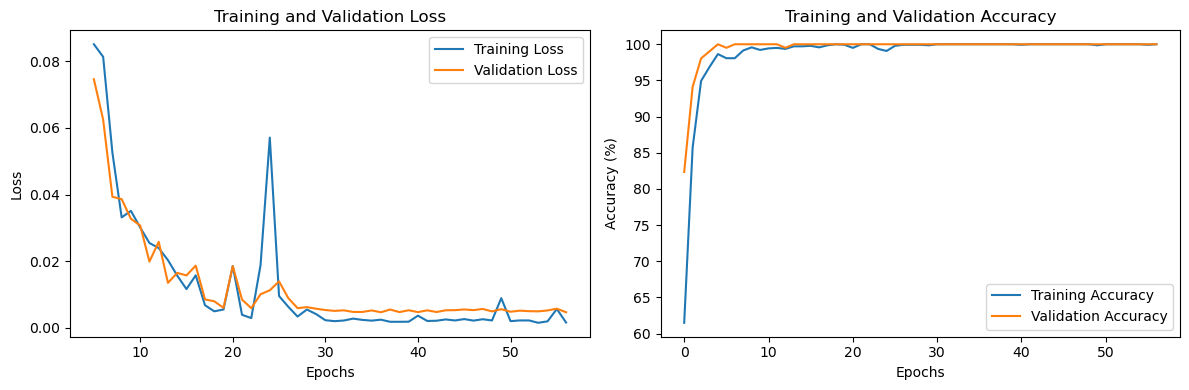

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  7 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 600.39it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:34<00:00, 106.51it/s]

Overall Score: 79.9%

Properties:
- Column Shapes: 76.13%
- Column Pair Trends: 83.67%
Epoch [1/10000], Avg. Training Loss: 0.6097687232223424, Training Accuracy: 67.71428571428571%, Avg. Validation Loss: 0.46043227269099307, Validation Accuracy: 78.92156862745098%
Epoch [2/10000], Avg. Training Loss: 0.3185137798163024, T

Epoch [42/10000], Avg. Training Loss: 0.041460487537154804, Training Accuracy: 99.78571428571429%, Avg. Validation Loss: 0.00347148236603691, Validation Accuracy: 100.0%
Epoch 00038: reducing learning rate of group 0 to 1.0000e-06.
Epoch [43/10000], Avg. Training Loss: 0.002033402669357284, Training Accuracy: 100.0%, Avg. Validation Loss: 0.00898872040068874, Validation Accuracy: 100.0%
Epoch [44/10000], Avg. Training Loss: 0.04311921407993809, Training Accuracy: 99.64285714285714%, Avg. Validation Loss: 0.007039544512875951, Validation Accuracy: 100.0%
Epoch [45/10000], Avg. Training Loss: 0.0012456362507112897, Training Accuracy: 100.0%, Avg. Validation Loss: 0.005677254010851567, Validation Accuracy: 100.0%
Epoch [46/10000], Avg. Training Loss: 0.0012406744334095326, Training Accuracy: 100.0%, Avg. Validation Loss: 0.005455329709757979, Validation Accuracy: 100.0%
Epoch 00042: reducing learning rate of group 0 to 1.0000e-07.
Epoch [47/10000], Avg. Training Loss: 0.001035932995364419

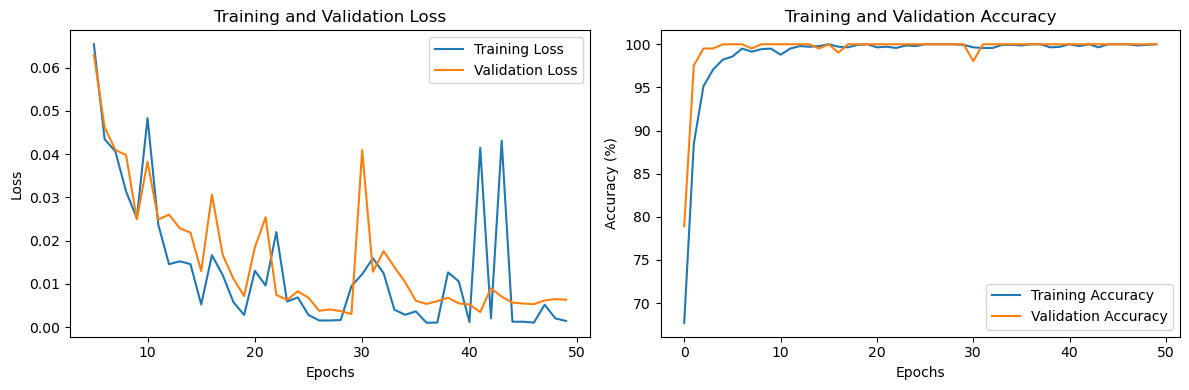

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  8 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 593.17it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:12<00:00, 109.18it/s]

Overall Score: 79.9%

Properties:
- Column Shapes: 76.13%
- Column Pair Trends: 83.67%
Epoch [1/10000], Avg. Training Loss: 0.5904952890493653, Training Accuracy: 68.78571428571429%, Avg. Validation Loss: 0.46832603445419896, Validation Accuracy: 75.98039215686275%
Epoch [2/10000], Avg. Training Loss: 0.30701195397837594, 

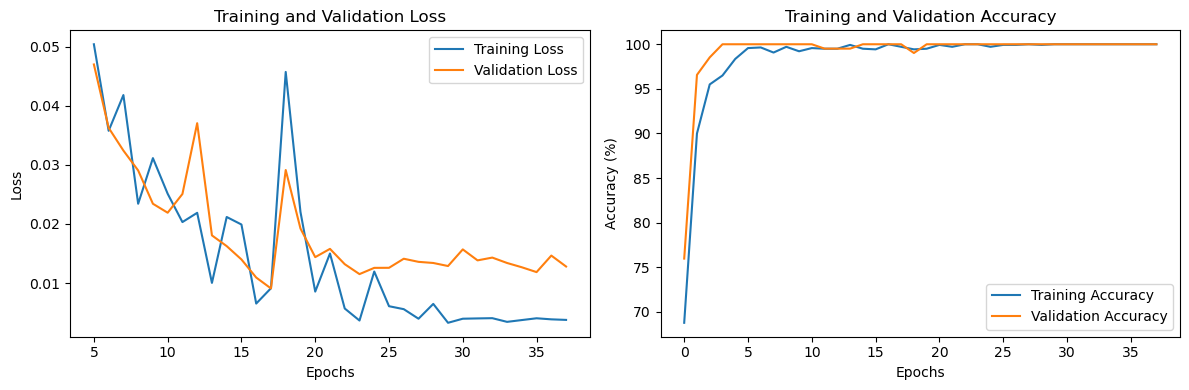

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  9 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 380.75it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:38<00:00, 106.03it/s]

Overall Score: 79.9%

Properties:
- Column Shapes: 76.13%
- Column Pair Trends: 83.67%
Epoch [1/10000], Avg. Training Loss: 0.6656084721061316, Training Accuracy: 64.0%, Avg. Validation Loss: 0.4765820021812732, Validation Accuracy: 81.37254901960785%
Epoch [2/10000], Avg. Training Loss: 0.36612446402961557, Training Accur

Epoch [42/10000], Avg. Training Loss: 0.0016124332234374544, Training Accuracy: 100.0%, Avg. Validation Loss: 0.005203825958932822, Validation Accuracy: 100.0%
Epoch [43/10000], Avg. Training Loss: 0.0016712890157412569, Training Accuracy: 100.0%, Avg. Validation Loss: 0.00555337188192285, Validation Accuracy: 100.0%
Epoch 00039: reducing learning rate of group 0 to 1.0000e-07.
Epoch [44/10000], Avg. Training Loss: 0.001549156074774642, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0048975328771540755, Validation Accuracy: 100.0%
Epoch [45/10000], Avg. Training Loss: 0.0015756155946953434, Training Accuracy: 100.0%, Avg. Validation Loss: 0.006078733740231166, Validation Accuracy: 100.0%
Epoch [46/10000], Avg. Training Loss: 0.0015684970395258542, Training Accuracy: 100.0%, Avg. Validation Loss: 0.005462963134050369, Validation Accuracy: 100.0%
Epoch [47/10000], Avg. Training Loss: 0.0011813830301848197, Training Accuracy: 100.0%, Avg. Validation Loss: 0.004847248693784842, Validat

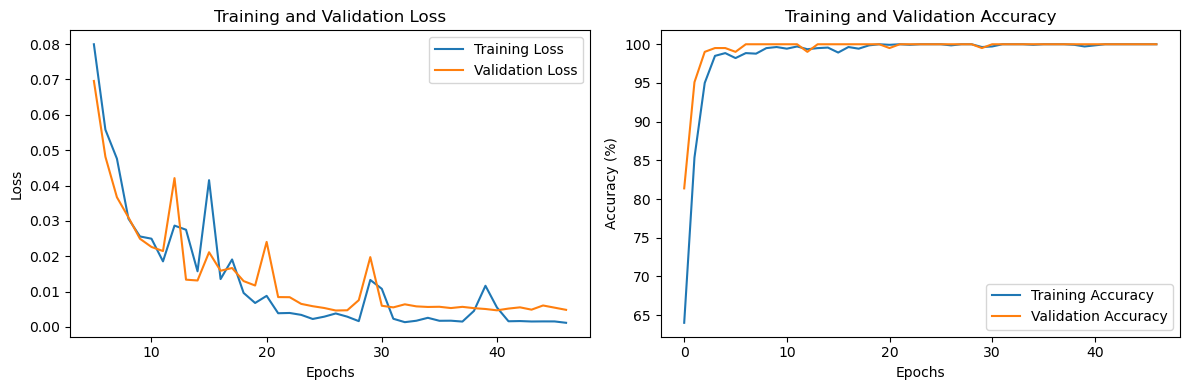

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  10 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 496.90it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [17:04<00:00, 90.86it/s]

Overall Score: 79.9%

Properties:
- Column Shapes: 76.13%
- Column Pair Trends: 83.67%
Epoch [1/10000], Avg. Training Loss: 0.5506308298896659, Training Accuracy: 71.0%, Avg. Validation Loss: 0.39359633509929365, Validation Accuracy: 90.19607843137256%
Epoch [2/10000], Avg. Training Loss: 0.28077790242704476, Training Acc

Epoch [43/10000], Avg. Training Loss: 0.006106571543403499, Training Accuracy: 99.85714285714286%, Avg. Validation Loss: 0.004539954834259474, Validation Accuracy: 100.0%
Epoch [44/10000], Avg. Training Loss: 0.004402800720775055, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.003889742620790807, Validation Accuracy: 100.0%
Epoch [45/10000], Avg. Training Loss: 0.0011365072924408278, Training Accuracy: 100.0%, Avg. Validation Loss: 0.004693695854467268, Validation Accuracy: 100.0%
Epoch [46/10000], Avg. Training Loss: 0.0014918526849214686, Training Accuracy: 100.0%, Avg. Validation Loss: 0.004950984175173709, Validation Accuracy: 100.0%
Epoch 00042: reducing learning rate of group 0 to 1.0000e-07.
Epoch [47/10000], Avg. Training Loss: 0.0011168006392174655, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0037242842193406364, Validation Accuracy: 100.0%
Epoch [48/10000], Avg. Training Loss: 0.001461156367936796, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0043

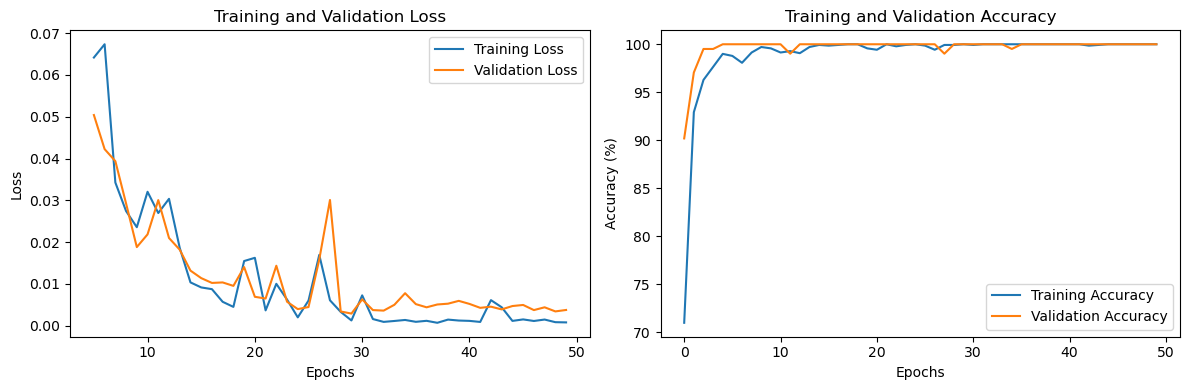

Accuracy of the network on the test set: 100.0 %


In [15]:
diagnostic_scores = []
diagnostic_validity = []
diagnostic_structure = []

quality_scores = []
quality_shapes = []
quality_trends = []

accuracies_all = []
accuracies_0 = []
accuracies_1 = []
accuracies_2 = []
accuracies_3 = []
accuracies_abn = []
for num_iter in range(10):
    print('##################################### Iteration ', num_iter+1, '#####################################')
    synthesizer = GaussianCopulaSynthesizer(metadata)
    synthesizer.fit(feature_matrix_nona_nostr)
    
    synthetic_data = synthesizer.sample(num_rows=1000)
    
    diagnostic = run_diagnostic(
        real_data=feature_matrix_nona_nostr,
        synthetic_data=synthetic_data,
        metadata=metadata
    )
    
    quality_report = evaluate_quality(
        feature_matrix_nona_nostr,
        synthetic_data,
        metadata
    )
    
    diagnostic_scores.append(diagnostic.get_score())
    diagnostic_validity.append(diagnostic.get_properties().at[0, 'Score'])
    diagnostic_structure.append(diagnostic.get_properties().at[1, 'Score'])
    
    quality_scores.append(quality_report.get_score())
    quality_shapes.append(quality_report.get_properties().at[0, 'Score'])
    quality_trends.append(quality_report.get_properties().at[1, 'Score'])
    
    acc_all, acc_0, acc_1, acc_2, acc_3, acc_abn = run_discriminator_training(synthetic_data)
    accuracies_all.append(acc_all)
    accuracies_0.append(acc_0)
    accuracies_1.append(acc_1)
    accuracies_2.append(acc_2)
    accuracies_3.append(acc_3)
    accuracies_abn.append(acc_abn)

In [16]:
{'diagnostic_score':np.mean(diagnostic_scores), 'diagnostic_validity':np.mean(diagnostic_validity), 'diagnostic_structure':np.mean(diagnostic_structure), 'quality_score':np.mean(quality_scores), 'quality_shapes':np.mean(quality_shapes), 'quality_trends':np.mean(quality_trends)}

{'diagnostic_score': 1.0,
 'diagnostic_validity': 1.0,
 'diagnostic_structure': 1.0,
 'quality_score': 0.7990212780854256,
 'quality_shapes': 0.7613016241299303,
 'quality_trends': 0.8367409320409209}

In [17]:
{'accuracy_all_data':np.mean(accuracies_all), 'accuracy_normal_users':np.mean(accuracies_0), 'accuracy_abnormal_1':np.mean(accuracies_1), 'accuracy_abnormal_2':np.mean(accuracies_2), 'accuracy_abnormal_3':np.mean(accuracies_3), 'accuracy_all_abnormal_users':np.mean(accuracies_abn)}

{'accuracy_all_data': 100.0,
 'accuracy_normal_users': 100.0,
 'accuracy_abnormal_1': 100.0,
 'accuracy_abnormal_2': 100.0,
 'accuracy_abnormal_3': 100.0,
 'accuracy_all_abnormal_users': 100.0}

### 2. DL

### 2.1 ctgan

##################################### Iteration  1 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)                                              11
NUM_UN

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 494.90it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:04<00:00, 110.25it/s]

Overall Score: 81.4%

Properties:
- Column Shapes: 77.4%
- Column Pair Trends: 85.4%
Epoch [1/10000], Avg. Training Loss: 0.6098845133727248, Training Accuracy: 65.28571428571429%, Avg. Validation Loss: 0.47254257477246797, Validation Accuracy: 78.92156862745098%
Epoch [2/10000], Avg. Training Loss: 0.36976809020746837, Training Accuracy: 86.5%, Avg. Validation Loss: 0.27339915243478924, Validation Accuracy: 94.11764705882354%
Epoch [3/10000], Avg. Training 

Epoch [45/10000], Avg. Training Loss: 0.0033980304526101627, Training Accuracy: 100.0%, Avg. Validation Loss: 0.010094502296012182, Validation Accuracy: 100.0%
Epoch [46/10000], Avg. Training Loss: 0.003142471237383275, Training Accuracy: 100.0%, Avg. Validation Loss: 0.010140386839898733, Validation Accuracy: 100.0%
Epoch [47/10000], Avg. Training Loss: 0.0036337128774241796, Training Accuracy: 100.0%, Avg. Validation Loss: 0.009605332707556395, Validation Accuracy: 100.0%
Epoch [48/10000], Avg. Training Loss: 0.006110807011613029, Training Accuracy: 99.85714285714286%, Avg. Validation Loss: 0.01010955970447797, Validation Accuracy: 100.0%
Epoch [49/10000], Avg. Training Loss: 0.0044913417699386955, Training Accuracy: 100.0%, Avg. Validation Loss: 0.010631592442783026, Validation Accuracy: 100.0%
Epoch [50/10000], Avg. Training Loss: 0.0037843978048344566, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0100900219180263, Validation Accuracy: 100.0%
Epoch [51/10000], Avg. Training L

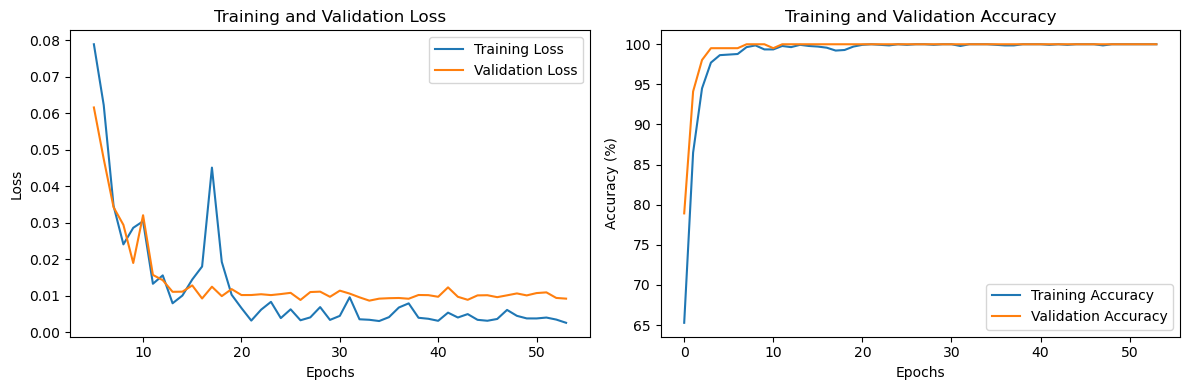

Accuracy of the network on the test set: 99.74747474747475 %
##################################### Iteration  2 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logo

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 680.56it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:06<00:00, 109.94it/s]

Overall Score: 82.6%

Properties:
- Column Shapes: 79.39%
- Column Pair Trends: 85.82%
Epoch [1/10000], Avg. Training Loss: 0.6290365115485408, Training Accuracy: 65.85714285714286%, Avg. Validation Loss: 0.5290647424184359, Validation Accuracy: 74.01960784313725%
Epoch [2/10000], Avg. Training Loss: 0.4077753885225816, Training Accuracy: 82.07142857142857%, Avg. Validation Loss: 0.3117661223961757, Validation Accuracy: 93.13725490196079%
Epoch [3/10000], Av

Epoch [46/10000], Avg. Training Loss: 0.0030988639227871317, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0074631822868608515, Validation Accuracy: 100.0%
Early stopping due to no improvement in validation loss.


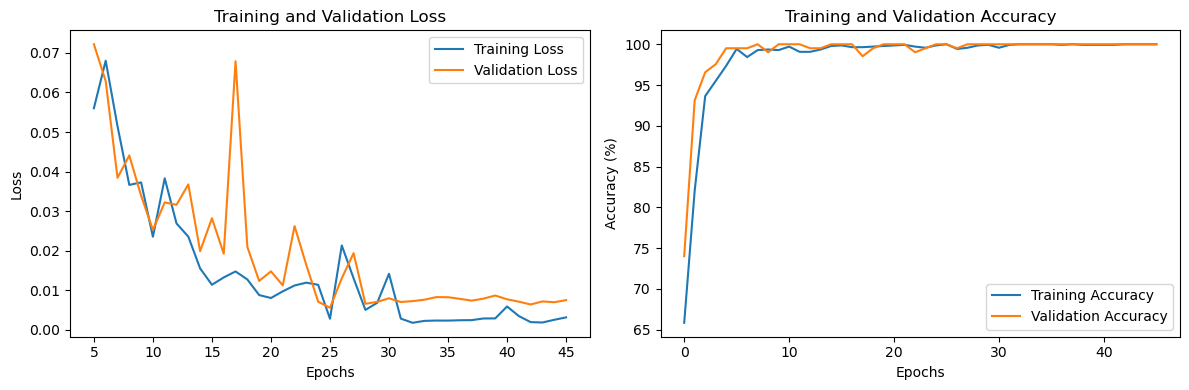

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  3 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)      

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 685.12it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:05<00:00, 110.10it/s]

Overall Score: 81.51%

Properties:
- Column Shapes: 77.52%
- Column Pair Trends: 85.5%
Epoch [1/10000], Avg. Training Loss: 0.7360673888840459, Training Accuracy: 58.57142857142857%, Avg. Validation Loss: 0.5534758682434375, Validation Accuracy: 72.05882352941177%
Epoch [2/10000], Avg. Training Loss: 0.4126705483279445, Training Accuracy: 84.57142857142857%, Avg. Validation Loss: 0.3093726806915723, Validation Accuracy: 93.62745098039215%
Epoch [3/10000], Av

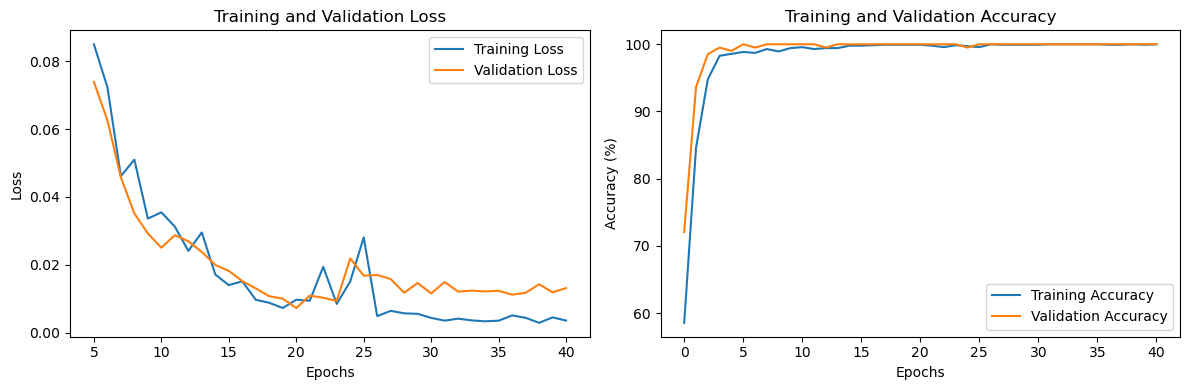

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  4 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)      

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 703.39it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:01<00:00, 110.57it/s]

Overall Score: 81.51%

Properties:
- Column Shapes: 77.18%
- Column Pair Trends: 85.85%
Epoch [1/10000], Avg. Training Loss: 0.6373448121276769, Training Accuracy: 61.142857142857146%, Avg. Validation Loss: 0.47498642252041745, Validation Accuracy: 75.49019607843137%
Epoch [2/10000], Avg. Training Loss: 0.36331984163685277, Training Accuracy: 86.28571428571429%, Avg. Validation Loss: 0.2672421175699968, Validation Accuracy: 95.58823529411765%
Epoch [3/10000]

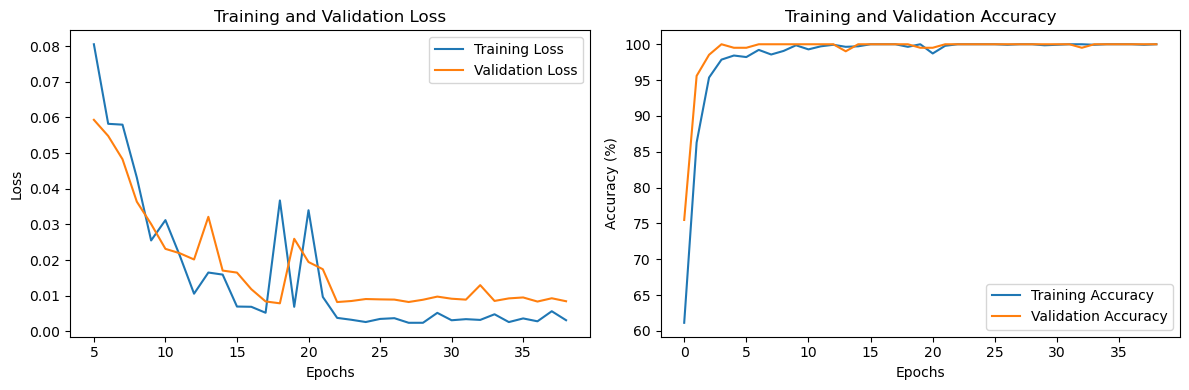

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  5 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)      

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 453.68it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:08<00:00, 109.73it/s]

Overall Score: 82.1%

Properties:
- Column Shapes: 78.2%
- Column Pair Trends: 86.01%
Epoch [1/10000], Avg. Training Loss: 0.5969782251526009, Training Accuracy: 69.57142857142857%, Avg. Validation Loss: 0.47885823020568263, Validation Accuracy: 80.88235294117646%
Epoch [2/10000], Avg. Training Loss: 0.38232742503962736, Training Accuracy: 85.5%, Avg. Validation Loss: 0.2697890206025197, Validation Accuracy: 93.62745098039215%
Epoch [3/10000], Avg. Training 

Epoch [45/10000], Avg. Training Loss: 0.003929219466292786, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.02532970679637331, Validation Accuracy: 99.50980392156863%
Early stopping due to no improvement in validation loss.


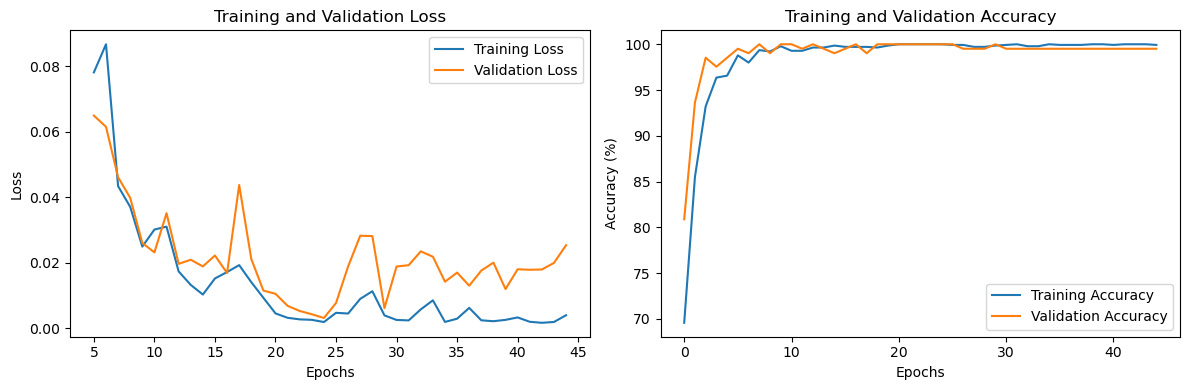

Accuracy of the network on the test set: 99.74747474747475 %
##################################### Iteration  6 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logo

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 662.19it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:06<00:00, 109.92it/s]

Overall Score: 81.9%

Properties:
- Column Shapes: 78.32%
- Column Pair Trends: 85.47%
Epoch [1/10000], Avg. Training Loss: 0.651934140785174, Training Accuracy: 63.357142857142854%, Avg. Validation Loss: 0.5308396953802842, Validation Accuracy: 70.58823529411765%
Epoch [2/10000], Avg. Training Loss: 0.43079159036278725, Training Accuracy: 84.42857142857143%, Avg. Validation Loss: 0.3596680026787978, Validation Accuracy: 92.15686274509804%
Epoch [3/10000], A

Epoch [46/10000], Avg. Training Loss: 0.0018035255568313667, Training Accuracy: 100.0%, Avg. Validation Loss: 0.006564537851283183, Validation Accuracy: 100.0%
Epoch 00042: reducing learning rate of group 0 to 1.0000e-06.
Epoch [47/10000], Avg. Training Loss: 0.008294019703581316, Training Accuracy: 99.78571428571429%, Avg. Validation Loss: 0.006040090515923042, Validation Accuracy: 100.0%
Epoch [48/10000], Avg. Training Loss: 0.0012843961862513838, Training Accuracy: 100.0%, Avg. Validation Loss: 0.00615592419098203, Validation Accuracy: 100.0%
Epoch [49/10000], Avg. Training Loss: 0.001605582219781354, Training Accuracy: 100.0%, Avg. Validation Loss: 0.006291924760891841, Validation Accuracy: 100.0%
Epoch [50/10000], Avg. Training Loss: 0.0015288458939308343, Training Accuracy: 100.0%, Avg. Validation Loss: 0.005651568313344167, Validation Accuracy: 100.0%
Epoch 00046: reducing learning rate of group 0 to 1.0000e-07.
Epoch [51/10000], Avg. Training Loss: 0.007349348547656767, Trainin

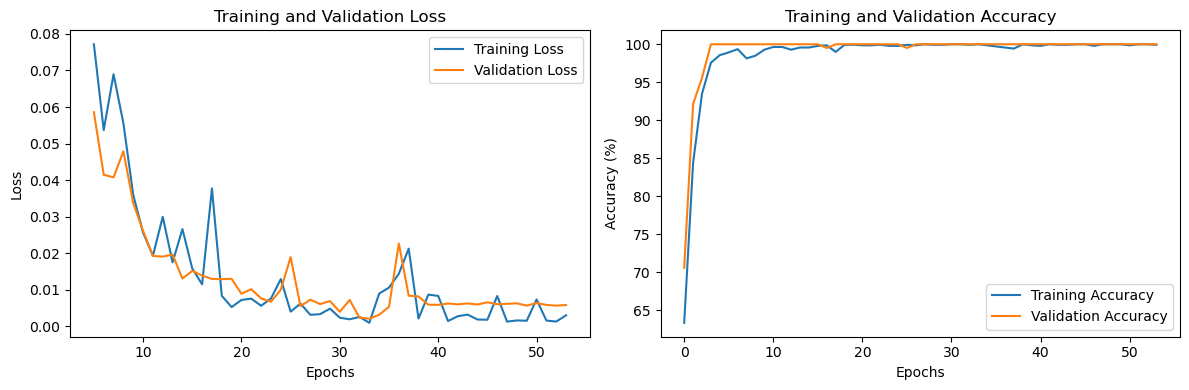

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  7 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)      

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 559.76it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:06<00:00, 109.96it/s]

Overall Score: 82.07%

Properties:
- Column Shapes: 78.21%
- Column Pair Trends: 85.93%
Epoch [1/10000], Avg. Training Loss: 0.6709954704750668, Training Accuracy: 63.07142857142857%, Avg. Validation Loss: 0.5197209257345933, Validation Accuracy: 69.6078431372549%
Epoch [2/10000], Avg. Training Loss: 0.3849990606646646, Training Accuracy: 83.64285714285714%, Avg. Validation Loss: 0.30909064755989957, Validation Accuracy: 86.76470588235294%
Epoch [3/10000], A

Epoch [44/10000], Avg. Training Loss: 0.0011858968156792055, Training Accuracy: 100.0%, Avg. Validation Loss: 0.02143621095456183, Validation Accuracy: 99.50980392156863%
Epoch [45/10000], Avg. Training Loss: 0.001443658180836461, Training Accuracy: 100.0%, Avg. Validation Loss: 0.017288702378909174, Validation Accuracy: 99.50980392156863%
Epoch [46/10000], Avg. Training Loss: 0.001674012943112757, Training Accuracy: 100.0%, Avg. Validation Loss: 0.02265104425784487, Validation Accuracy: 99.50980392156863%
Epoch [47/10000], Avg. Training Loss: 0.0019491181532926435, Training Accuracy: 100.0%, Avg. Validation Loss: 0.01895392229422354, Validation Accuracy: 99.50980392156863%
Early stopping due to no improvement in validation loss.


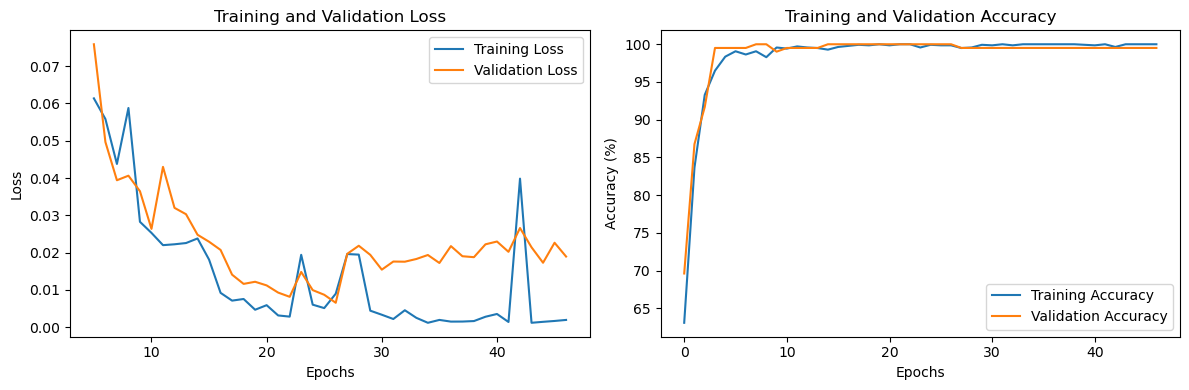

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  8 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)      

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 505.58it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:07<00:00, 109.85it/s]

Overall Score: 81.59%

Properties:
- Column Shapes: 77.75%
- Column Pair Trends: 85.44%
Epoch [1/10000], Avg. Training Loss: 0.6176154315471649, Training Accuracy: 66.78571428571429%, Avg. Validation Loss: 0.6212501640503223, Validation Accuracy: 67.15686274509804%
Epoch [2/10000], Avg. Training Loss: 0.39314150166782463, Training Accuracy: 87.28571428571429%, Avg. Validation Loss: 0.3978690482102908, Validation Accuracy: 86.76470588235294%
Epoch [3/10000], 

Epoch [46/10000], Avg. Training Loss: 0.0010024298588343133, Training Accuracy: 100.0%, Avg. Validation Loss: 0.002958287028237604, Validation Accuracy: 100.0%
Epoch 00042: reducing learning rate of group 0 to 1.0000e-06.
Epoch [47/10000], Avg. Training Loss: 0.0010678521463308823, Training Accuracy: 100.0%, Avg. Validation Loss: 0.003328505652741744, Validation Accuracy: 100.0%
Epoch [48/10000], Avg. Training Loss: 0.0013315993067160227, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0026724209220936666, Validation Accuracy: 100.0%
Epoch [49/10000], Avg. Training Loss: 0.0010084522056620865, Training Accuracy: 100.0%, Avg. Validation Loss: 0.003029848001180933, Validation Accuracy: 100.0%
Epoch [50/10000], Avg. Training Loss: 0.0012032858129797123, Training Accuracy: 100.0%, Avg. Validation Loss: 0.00327936654838805, Validation Accuracy: 100.0%
Epoch 00046: reducing learning rate of group 0 to 1.0000e-07.
Epoch [51/10000], Avg. Training Loss: 0.006805722332997407, Training Accurac

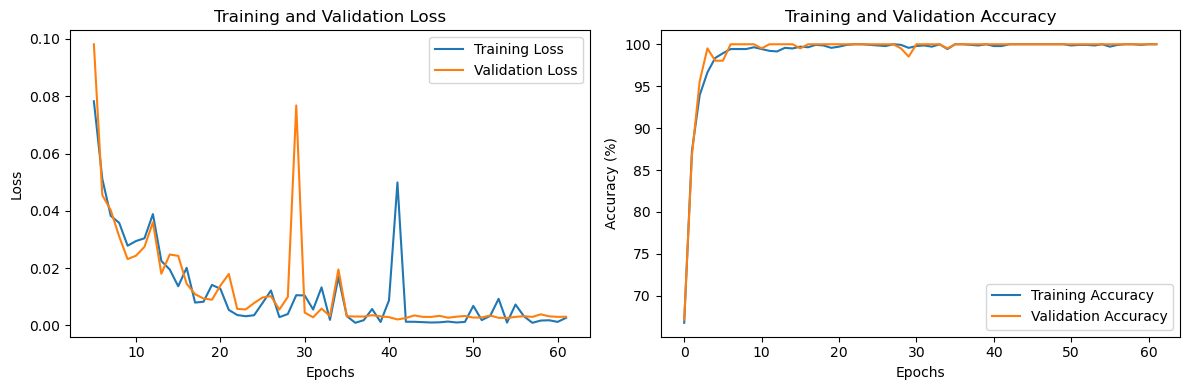

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  9 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)      

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 641.82it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:03<00:00, 110.32it/s]

Overall Score: 82.07%

Properties:
- Column Shapes: 78.29%
- Column Pair Trends: 85.84%
Epoch [1/10000], Avg. Training Loss: 0.7388192533769391, Training Accuracy: 54.42857142857143%, Avg. Validation Loss: 0.6020084757071275, Validation Accuracy: 64.70588235294117%
Epoch [2/10000], Avg. Training Loss: 0.471046660434116, Training Accuracy: 79.42857142857143%, Avg. Validation Loss: 0.39510064170910764, Validation Accuracy: 89.2156862745098%
Epoch [3/10000], Av

Epoch [47/10000], Avg. Training Loss: 0.003513377158841732, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.007069395049116933, Validation Accuracy: 100.0%
Epoch [48/10000], Avg. Training Loss: 0.0023395286582606127, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.006224010014333404, Validation Accuracy: 100.0%
Epoch [49/10000], Avg. Training Loss: 0.0014955244458344002, Training Accuracy: 100.0%, Avg. Validation Loss: 0.006840594542714266, Validation Accuracy: 100.0%
Epoch [50/10000], Avg. Training Loss: 0.003392212672637966, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.006070608702989725, Validation Accuracy: 100.0%
Early stopping due to no improvement in validation loss.


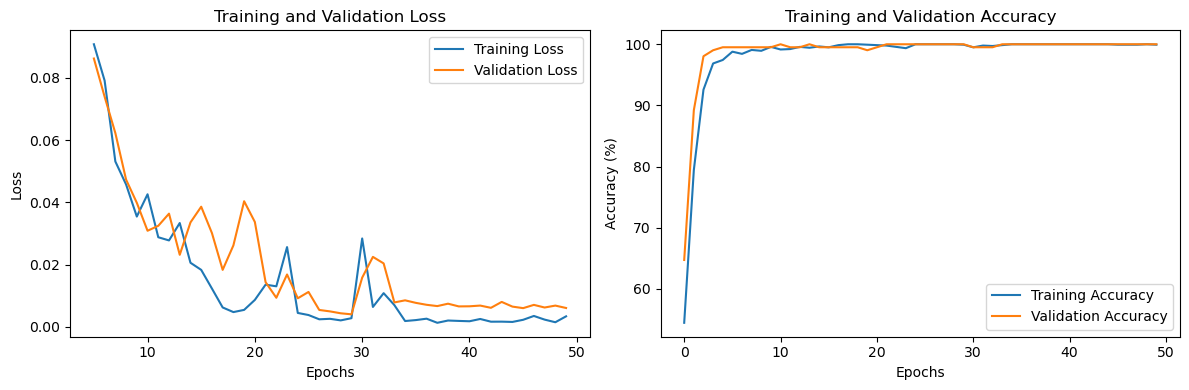

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  10 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)     

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 573.93it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:09<00:00, 109.65it/s]

Overall Score: 82.21%

Properties:
- Column Shapes: 78.32%
- Column Pair Trends: 86.11%
Epoch [1/10000], Avg. Training Loss: 0.6466415114700794, Training Accuracy: 67.14285714285714%, Avg. Validation Loss: 0.4819346299538246, Validation Accuracy: 82.3529411764706%
Epoch [2/10000], Avg. Training Loss: 0.33706949617375026, Training Accuracy: 88.0%, Avg. Validation Loss: 0.25824038225870866, Validation Accuracy: 95.58823529411765%
Epoch [3/10000], Avg. Training

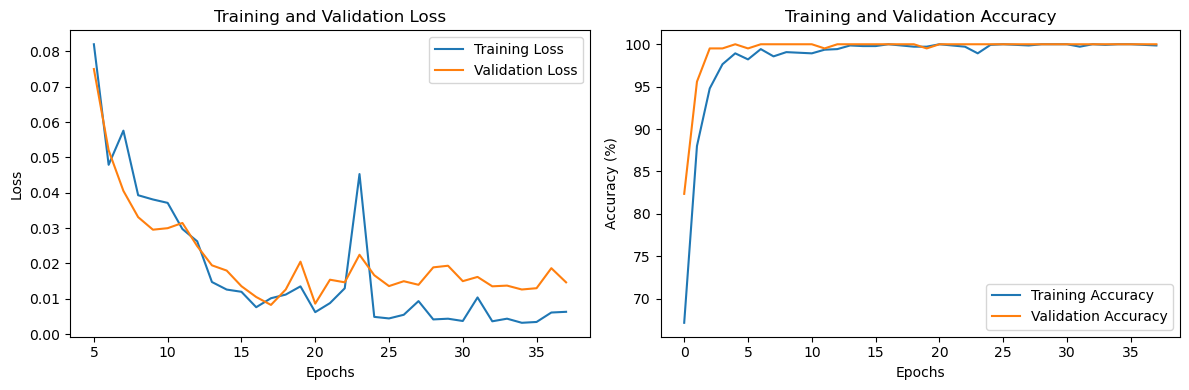

Accuracy of the network on the test set: 99.74747474747475 %


In [18]:
diagnostic_scores = []
diagnostic_validity = []
diagnostic_structure = []

quality_scores = []
quality_shapes = []
quality_trends = []

accuracies_all = []
accuracies_0 = []
accuracies_1 = []
accuracies_2 = []
accuracies_3 = []
accuracies_abn = []
for num_iter in range(10):
    print('##################################### Iteration ', num_iter+1, '#####################################')
    synthesizer = CTGANSynthesizer(metadata)
    synthesizer.fit(feature_matrix_nona_nostr)
    
    synthetic_data = synthesizer.sample(num_rows=1000)
    
    diagnostic = run_diagnostic(
        real_data=feature_matrix_nona_nostr,
        synthetic_data=synthetic_data,
        metadata=metadata
    )
    
    quality_report = evaluate_quality(
        feature_matrix_nona_nostr,
        synthetic_data,
        metadata
    )
    
    diagnostic_scores.append(diagnostic.get_score())
    diagnostic_validity.append(diagnostic.get_properties().at[0, 'Score'])
    diagnostic_structure.append(diagnostic.get_properties().at[1, 'Score'])
    
    quality_scores.append(quality_report.get_score())
    quality_shapes.append(quality_report.get_properties().at[0, 'Score'])
    quality_trends.append(quality_report.get_properties().at[1, 'Score'])
    
    acc_all, acc_0, acc_1, acc_2, acc_3, acc_abn = run_discriminator_training(synthetic_data)
    accuracies_all.append(acc_all)
    accuracies_0.append(acc_0)
    accuracies_1.append(acc_1)
    accuracies_2.append(acc_2)
    accuracies_3.append(acc_3)
    accuracies_abn.append(acc_abn)

In [19]:
{'diagnostic_score':np.mean(diagnostic_scores), 'diagnostic_validity':np.mean(diagnostic_validity), 'diagnostic_structure':np.mean(diagnostic_structure), 'quality_score':np.mean(quality_scores), 'quality_shapes':np.mean(quality_shapes), 'quality_trends':np.mean(quality_trends)}

{'diagnostic_score': 1.0,
 'diagnostic_validity': 1.0,
 'diagnostic_structure': 1.0,
 'quality_score': 0.8189759435114597,
 'quality_shapes': 0.7805742459396752,
 'quality_trends': 0.8573776410832441}

In [20]:
{'accuracy_all_data':np.mean(accuracies_all), 'accuracy_normal_users':np.mean(accuracies_0), 'accuracy_abnormal_1':np.mean(accuracies_1), 'accuracy_abnormal_2':np.mean(accuracies_2), 'accuracy_abnormal_3':np.mean(accuracies_3), 'accuracy_all_abnormal_users':np.mean(accuracies_abn)}

{'accuracy_all_data': 99.92424242424242,
 'accuracy_normal_users': 99.91627194983377,
 'accuracy_abnormal_1': 100.0,
 'accuracy_abnormal_2': 100.0,
 'accuracy_abnormal_3': 100.0,
 'accuracy_all_abnormal_users': 100.0}

### 2.2 autoencoder

##################################### Iteration  1 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 437.64it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [17:20<00:00, 89.46it/s]

Overall Score: 83.92%

Properties:
- Column Shapes: 83.25%
- Column Pair Trends: 84.58%
Epoch [1/10000], Avg. Training Loss: 0.6497756710106676, Training Accuracy: 62.642857142857146%, Avg. Validation Loss: 0.5690449476242065, Validation Accuracy: 75.49019607843137%
Epoch [2/10000], Avg. Training Loss: 0.49205758795142174, Training Accuracy: 78.28571428571429%, Avg. Vali

Epoch [43/10000], Avg. Training Loss: 0.005597584997303784, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.036911836896951385, Validation Accuracy: 99.50980392156863%
Epoch [44/10000], Avg. Training Loss: 0.009590185592638922, Training Accuracy: 99.85714285714286%, Avg. Validation Loss: 0.04161666964109127, Validation Accuracy: 99.50980392156863%
Epoch [45/10000], Avg. Training Loss: 0.0057891936250433155, Training Accuracy: 100.0%, Avg. Validation Loss: 0.043489888740273625, Validation Accuracy: 99.01960784313725%
Epoch [46/10000], Avg. Training Loss: 0.013263920426569794, Training Accuracy: 99.64285714285714%, Avg. Validation Loss: 0.04142870675199307, Validation Accuracy: 99.01960784313725%
Epoch [47/10000], Avg. Training Loss: 0.010565207329240035, Training Accuracy: 99.78571428571429%, Avg. Validation Loss: 0.0397489291544144, Validation Accuracy: 99.50980392156863%
Epoch 00043: reducing learning rate of group 0 to 1.0000e-08.
Epoch [48/10000], Avg. Training Loss: 

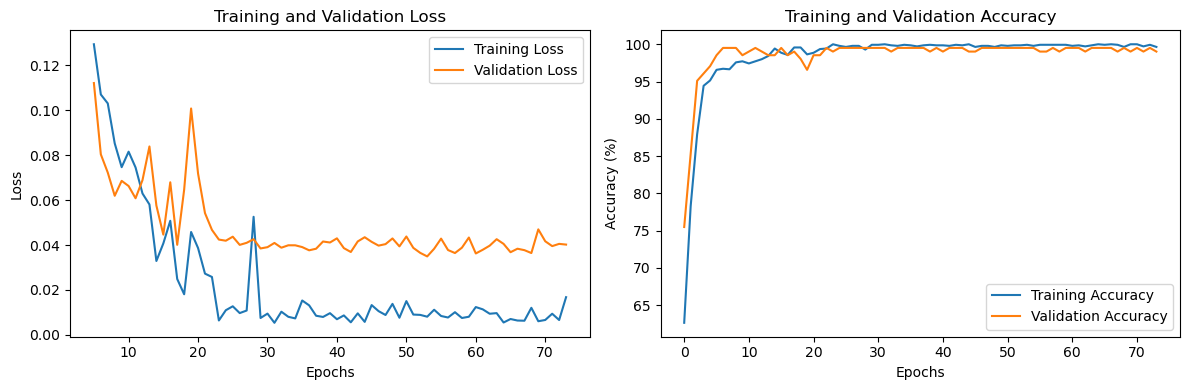

Accuracy of the network on the test set: 99.4949494949495 %
##################################### Iteration  2 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 376.71it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [16:14<00:00, 95.52it/s]

Overall Score: 83.79%

Properties:
- Column Shapes: 83.15%
- Column Pair Trends: 84.44%
Epoch [1/10000], Avg. Training Loss: 0.7128187299452045, Training Accuracy: 59.642857142857146%, Avg. Validation Loss: 0.7058325547438401, Validation Accuracy: 66.17647058823529%
Epoch [2/10000], Avg. Training Loss: 0.5153123

Epoch [44/10000], Avg. Training Loss: 0.007446389307998205, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.02517536970285269, Validation Accuracy: 100.0%
Epoch [45/10000], Avg. Training Loss: 0.005352709410627457, Training Accuracy: 100.0%, Avg. Validation Loss: 0.02988689808318248, Validation Accuracy: 100.0%
Epoch [46/10000], Avg. Training Loss: 0.005983858285948041, Training Accuracy: 100.0%, Avg. Validation Loss: 0.02808157490709653, Validation Accuracy: 100.0%
Epoch [47/10000], Avg. Training Loss: 0.008517497010126879, Training Accuracy: 99.85714285714286%, Avg. Validation Loss: 0.028303616107083283, Validation Accuracy: 100.0%
Epoch [48/10000], Avg. Training Loss: 0.01298375836764039, Training Accuracy: 99.64285714285714%, Avg. Validation Loss: 0.02602683022045172, Validation Accuracy: 100.0%
Epoch 00044: reducing learning rate of group 0 to 1.0000e-08.
Epoch [49/10000], Avg. Training Loss: 0.010668349720865743, Training Accuracy: 99.71428571428571%, Avg. Validati

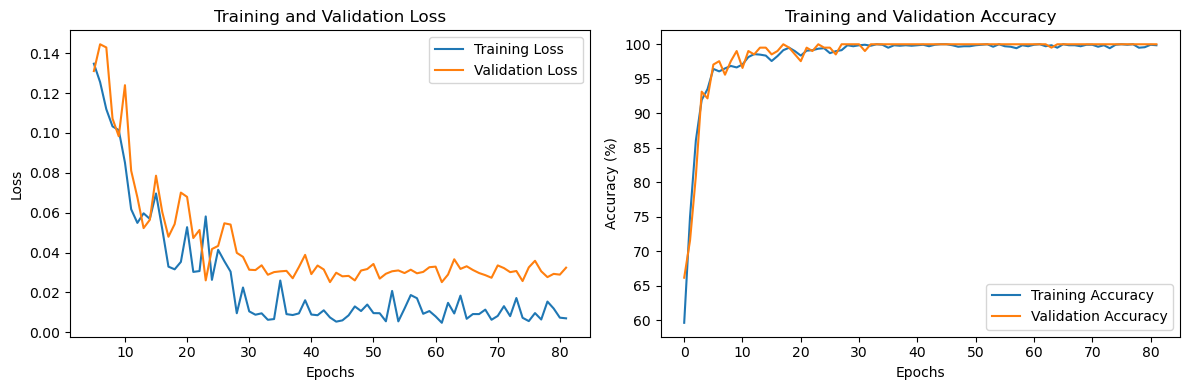

Accuracy of the network on the test set: 99.4949494949495 %
##################################### Iteration  3 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 627.51it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [16:07<00:00, 96.18it/s]

Overall Score: 83.51%

Properties:
- Column Shapes: 83.38%
- Column Pair Trends: 83.64%
Epoch [1/10000], Avg. Training Loss: 0.6533872942355546, Training Accuracy: 64.42857142857143%, Avg. Validation Loss: 0.5634477849190052, Validation Accuracy: 72.54901960784314%
Epoch [2/10000], Avg. Training Loss: 0.49504863

Epoch [43/10000], Avg. Training Loss: 0.010609766060952097, Training Accuracy: 99.85714285714286%, Avg. Validation Loss: 0.05443407953358614, Validation Accuracy: 97.54901960784314%
Epoch [44/10000], Avg. Training Loss: 0.012976174420063298, Training Accuracy: 99.71428571428571%, Avg. Validation Loss: 0.047409165364045366, Validation Accuracy: 98.52941176470588%
Epoch 00040: reducing learning rate of group 0 to 1.0000e-07.
Epoch [45/10000], Avg. Training Loss: 0.018877352810126136, Training Accuracy: 99.5%, Avg. Validation Loss: 0.05000465821761351, Validation Accuracy: 98.03921568627452%
Epoch [46/10000], Avg. Training Loss: 0.008694532470227305, Training Accuracy: 100.0%, Avg. Validation Loss: 0.05598012974055914, Validation Accuracy: 98.03921568627452%
Epoch [47/10000], Avg. Training Loss: 0.036053188295971435, Training Accuracy: 99.28571428571429%, Avg. Validation Loss: 0.0427963832536569, Validation Accuracy: 99.01960784313725%
Epoch [48/10000], Avg. Training Loss: 0.0147251875076

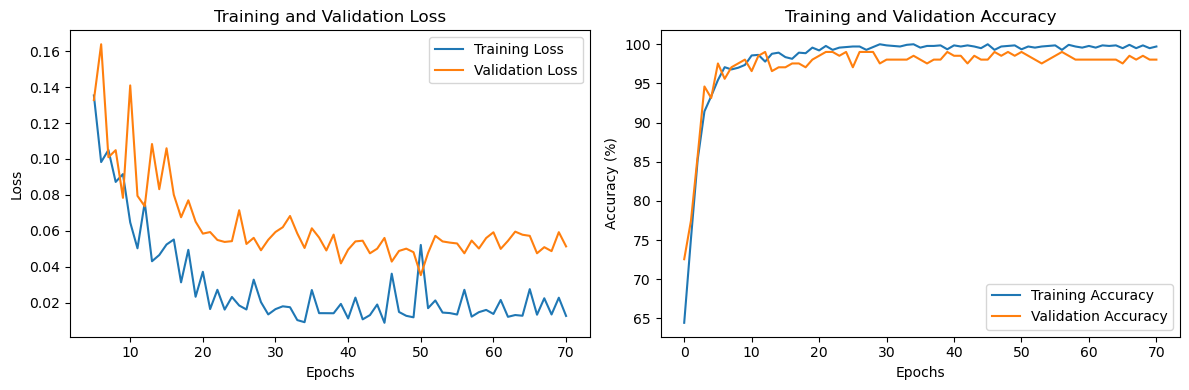

Accuracy of the network on the test set: 99.24242424242425 %
##################################### Iteration  4 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 542.11it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [17:42<00:00, 87.63it/s]

Overall Score: 83.97%

Properties:
- Column Shapes: 83.37%
- Column Pair Trends: 84.56%
Epoch [1/10000], Avg. Training Loss: 0.6945336234163154, Training Accuracy: 59.214285714285715%, Avg. Validation Loss: 0.5833788674611312, Validation Accuracy: 73.03921568627452%
Epoch [2/10000], Avg. Training Loss: 0.488661

Epoch [44/10000], Avg. Training Loss: 0.010080928046425635, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.041315633875246234, Validation Accuracy: 99.01960784313725%
Epoch [45/10000], Avg. Training Loss: 0.01799266832743094, Training Accuracy: 99.71428571428571%, Avg. Validation Loss: 0.04572631253932531, Validation Accuracy: 99.01960784313725%
Epoch [46/10000], Avg. Training Loss: 0.011815353566569022, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.03822241573093029, Validation Accuracy: 99.01960784313725%
Epoch [47/10000], Avg. Training Loss: 0.03282193616773425, Training Accuracy: 99.07142857142857%, Avg. Validation Loss: 0.04033935528535109, Validation Accuracy: 98.52941176470588%
Epoch [48/10000], Avg. Training Loss: 0.014149446815612133, Training Accuracy: 99.57142857142857%, Avg. Validation Loss: 0.041464441599181064, Validation Accuracy: 99.01960784313725%
Epoch [49/10000], Avg. Training Loss: 0.012407074818673374, Training Accuracy: 99.64285714

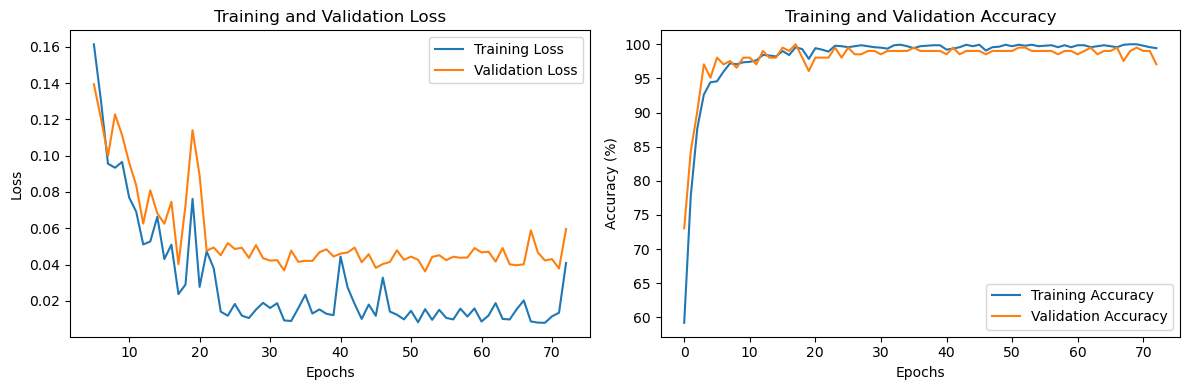

Accuracy of the network on the test set: 98.98989898989899 %
##################################### Iteration  5 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 402.64it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [17:24<00:00, 89.13it/s]

Overall Score: 84.17%

Properties:
- Column Shapes: 83.68%
- Column Pair Trends: 84.66%
Epoch [1/10000], Avg. Training Loss: 0.6383348015899007, Training Accuracy: 63.857142857142854%, Avg. Validation Loss: 0.5655622161351718, Validation Accuracy: 75.98039215686275%
Epoch [2/10000], Avg. Training Loss: 0.484289

Epoch [43/10000], Avg. Training Loss: 0.006951234516401944, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.05140813891417705, Validation Accuracy: 98.52941176470588%
Epoch [44/10000], Avg. Training Loss: 0.011467755475843494, Training Accuracy: 99.78571428571429%, Avg. Validation Loss: 0.05599079023186977, Validation Accuracy: 98.03921568627452%
Epoch [45/10000], Avg. Training Loss: 0.010642393066187982, Training Accuracy: 99.78571428571429%, Avg. Validation Loss: 0.049745364544483334, Validation Accuracy: 99.01960784313725%
Epoch [46/10000], Avg. Training Loss: 0.006544251975190657, Training Accuracy: 100.0%, Avg. Validation Loss: 0.05794423789932178, Validation Accuracy: 98.52941176470588%
Epoch 00042: reducing learning rate of group 0 to 1.0000e-08.
Epoch [47/10000], Avg. Training Loss: 0.048053455822148615, Training Accuracy: 99.28571428571429%, Avg. Validation Loss: 0.06747775317098086, Validation Accuracy: 98.52941176470588%
Epoch [48/10000], Avg. Training Loss: 0

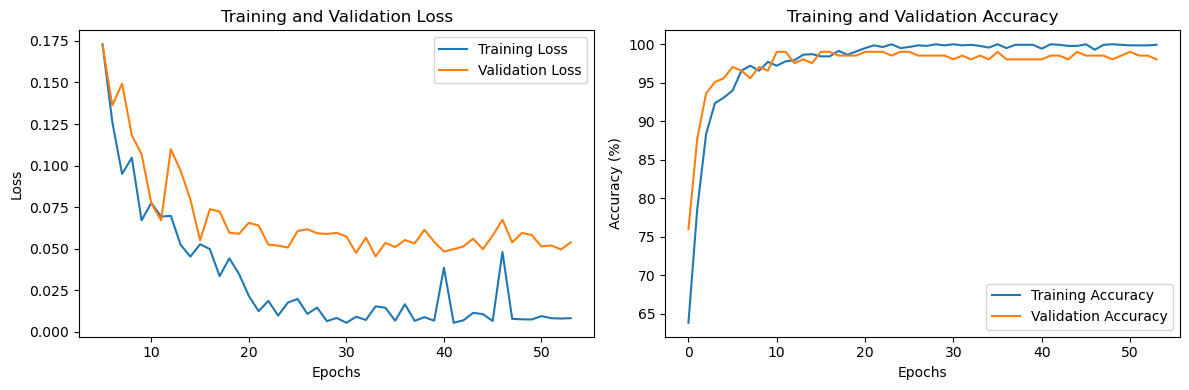

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  6 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 433.47it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [16:05<00:00, 96.38it/s]

Overall Score: 83.6%

Properties:
- Column Shapes: 83.49%
- Column Pair Trends: 83.71%
Epoch [1/10000], Avg. Training Loss: 0.5909831398590044, Training Accuracy: 70.71428571428571%, Avg. Validation Loss: 0.5046815321995661, Validation Accuracy: 75.0%
Epoch [2/10000], Avg. Training Loss: 0.39990839904004877, Training Accur

Epoch [43/10000], Avg. Training Loss: 0.011331695682284508, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.04102635125701244, Validation Accuracy: 99.50980392156863%
Epoch [44/10000], Avg. Training Loss: 0.012620803966208106, Training Accuracy: 99.71428571428571%, Avg. Validation Loss: 0.04127381870952936, Validation Accuracy: 99.50980392156863%
Epoch 00040: reducing learning rate of group 0 to 1.0000e-08.
Epoch [45/10000], Avg. Training Loss: 0.017197456337850203, Training Accuracy: 99.78571428571429%, Avg. Validation Loss: 0.03897887468338013, Validation Accuracy: 99.50980392156863%
Epoch [46/10000], Avg. Training Loss: 0.008175119318449024, Training Accuracy: 100.0%, Avg. Validation Loss: 0.04625864656498799, Validation Accuracy: 99.50980392156863%
Epoch [47/10000], Avg. Training Loss: 0.012587433620038528, Training Accuracy: 99.78571428571429%, Avg. Validation Loss: 0.039709808448186286, Validation Accuracy: 99.50980392156863%
Epoch [48/10000], Avg. Training Loss: 0

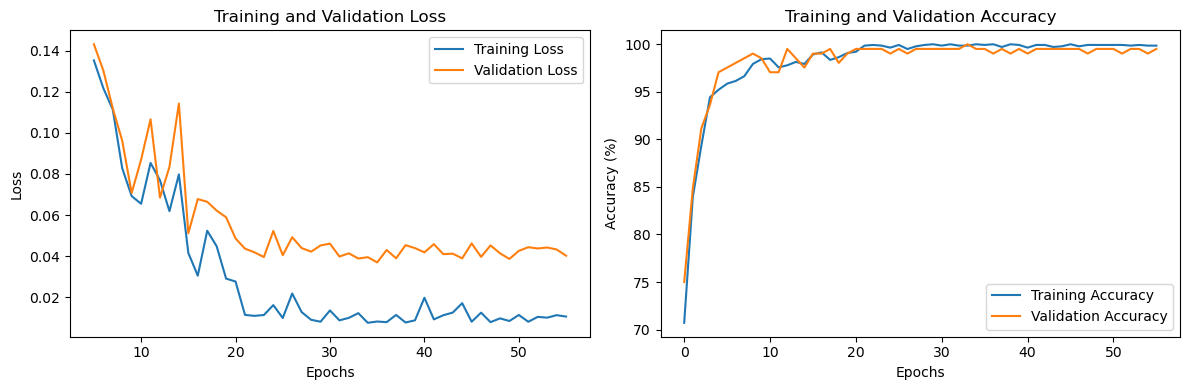

Accuracy of the network on the test set: 99.4949494949495 %
##################################### Iteration  7 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 460.66it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:59<00:00, 103.51it/s]

Overall Score: 83.25%

Properties:
- Column Shapes: 83.19%
- Column Pair Trends: 83.31%
Epoch [1/10000], Avg. Training Loss: 0.7180689735846086, Training Accuracy: 59.142857142857146%, Avg. Validation Loss: 0.5479251513114343, Validation Accuracy: 69.11764705882354%
Epoch [2/10000], Avg. Training Loss: 0.4894901

Epoch [43/10000], Avg. Training Loss: 0.012719891555289823, Training Accuracy: 99.85714285714286%, Avg. Validation Loss: 0.03857641953688402, Validation Accuracy: 99.50980392156863%
Epoch [44/10000], Avg. Training Loss: 0.010272557939804921, Training Accuracy: 100.0%, Avg. Validation Loss: 0.03970370957484612, Validation Accuracy: 99.01960784313725%
Epoch [45/10000], Avg. Training Loss: 0.01567269016099586, Training Accuracy: 99.78571428571429%, Avg. Validation Loss: 0.03651061410514208, Validation Accuracy: 99.50980392156863%
Epoch [46/10000], Avg. Training Loss: 0.010974132048431784, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.03716590255498886, Validation Accuracy: 99.50980392156863%
Epoch [47/10000], Avg. Training Loss: 0.017100881041683766, Training Accuracy: 99.64285714285714%, Avg. Validation Loss: 0.034699422952074274, Validation Accuracy: 100.0%
Epoch [48/10000], Avg. Training Loss: 0.01091754575926726, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0375

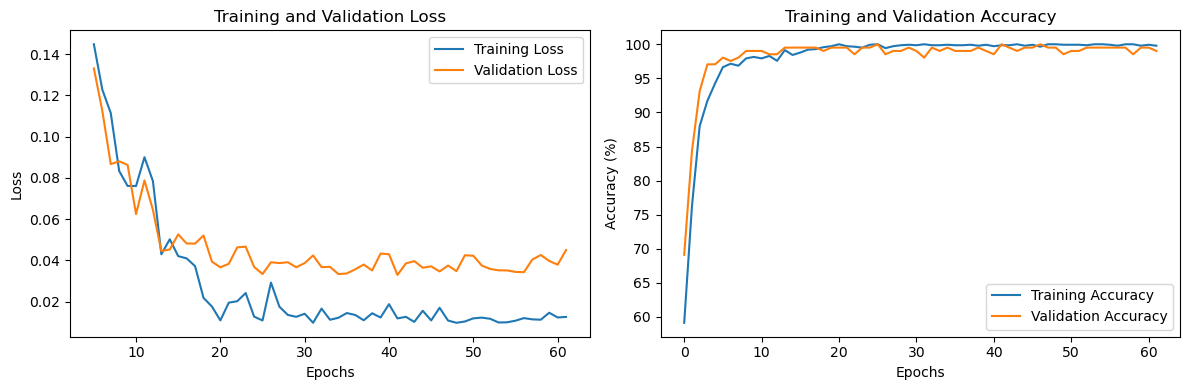

Accuracy of the network on the test set: 99.4949494949495 %
##################################### Iteration  8 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 454.82it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [15:01<00:00, 103.30it/s]

Overall Score: 84.11%

Properties:
- Column Shapes: 83.7%
- Column Pair Trends: 84.52%
Epoch [1/10000], Avg. Training Loss: 0.6468762484463778, Training Accuracy: 64.5%, Avg. Validation Loss: 0.5473278554586264, Validation Accuracy: 74.01960784313725%
Epoch [2/10000], Avg. Training Loss: 0.4359359609132463, Trai

Epoch [46/10000], Avg. Training Loss: 0.006136152952835387, Training Accuracy: 99.85714285714286%, Avg. Validation Loss: 0.024121124870502032, Validation Accuracy: 99.01960784313725%
Epoch [47/10000], Avg. Training Loss: 0.011297013614570129, Training Accuracy: 99.71428571428571%, Avg. Validation Loss: 0.02358306385576725, Validation Accuracy: 100.0%
Epoch 00043: reducing learning rate of group 0 to 1.0000e-07.
Epoch [48/10000], Avg. Training Loss: 0.005449719924151644, Training Accuracy: 100.0%, Avg. Validation Loss: 0.02666360978037119, Validation Accuracy: 100.0%
Epoch [49/10000], Avg. Training Loss: 0.006768634811371819, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.021033884599231757, Validation Accuracy: 100.0%
Epoch [50/10000], Avg. Training Loss: 0.015899534042215568, Training Accuracy: 99.78571428571429%, Avg. Validation Loss: 0.023596325387748387, Validation Accuracy: 100.0%
Epoch [51/10000], Avg. Training Loss: 0.004906932857755402, Training Accuracy: 100.0%

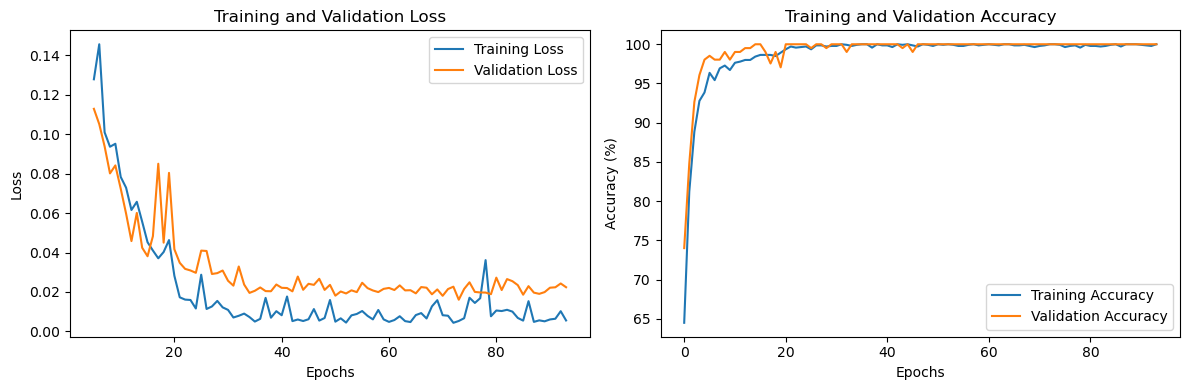

Accuracy of the network on the test set: 98.73737373737374 %
##################################### Iteration  9 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 355.45it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:43<00:00, 105.35it/s]

Overall Score: 84.6%

Properties:
- Column Shapes: 84.36%
- Column Pair Trends: 84.83%
Epoch [1/10000], Avg. Training Loss: 0.7074968195097013, Training Accuracy: 61.0%, Avg. Validation Loss: 0.6392520666122437, Validation Accuracy: 60.294117647058826%
Epoch [2/10000], Avg. Training Loss: 0.5399122481996362, Tr

Epoch [45/10000], Avg. Training Loss: 0.011479325925889001, Training Accuracy: 99.85714285714286%, Avg. Validation Loss: 0.037819632257406526, Validation Accuracy: 99.01960784313725%
Epoch 00041: reducing learning rate of group 0 to 1.0000e-07.
Epoch [46/10000], Avg. Training Loss: 0.009814987355970185, Training Accuracy: 99.78571428571429%, Avg. Validation Loss: 0.03500610024023514, Validation Accuracy: 99.01960784313725%
Epoch [47/10000], Avg. Training Loss: 0.014477602994619783, Training Accuracy: 99.64285714285714%, Avg. Validation Loss: 0.02786025182845501, Validation Accuracy: 99.50980392156863%
Epoch [48/10000], Avg. Training Loss: 0.008065218915527856, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.03133551633128753, Validation Accuracy: 99.50980392156863%
Epoch [49/10000], Avg. Training Loss: 0.025777787758587776, Training Accuracy: 99.5%, Avg. Validation Loss: 0.029457248747348785, Validation Accuracy: 99.50980392156863%
Epoch 00045: reducing learning rate of 

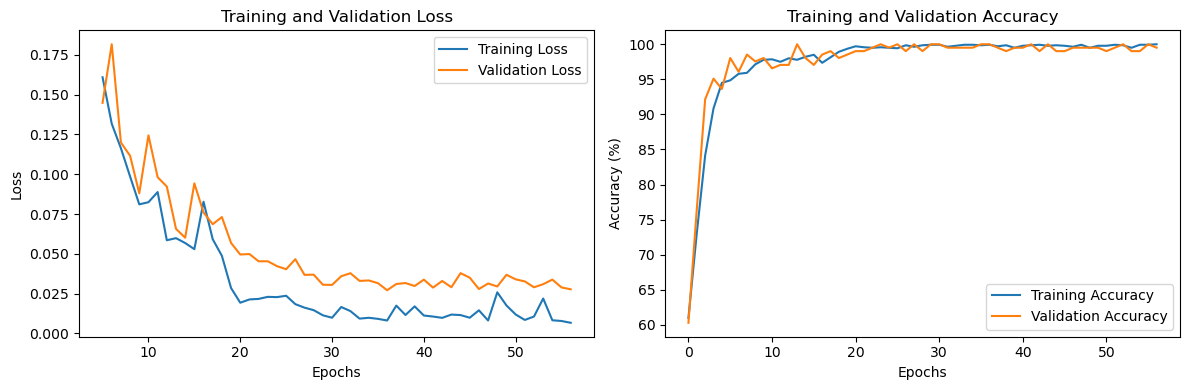

Accuracy of the network on the test set: 99.24242424242425 %
##################################### Iteration  10 #####################################
Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 658.34it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [17:18<00:00, 89.65it/s]

Overall Score: 83.56%

Properties:
- Column Shapes: 83.55%
- Column Pair Trends: 83.56%
Epoch [1/10000], Avg. Training Loss: 0.7311580922793258, Training Accuracy: 61.07142857142857%, Avg. Validation Loss: 0.5643893572000357, Validation Accuracy: 68.13725490196079%
Epoch [2/10000], Avg. Training Loss: 0.443636

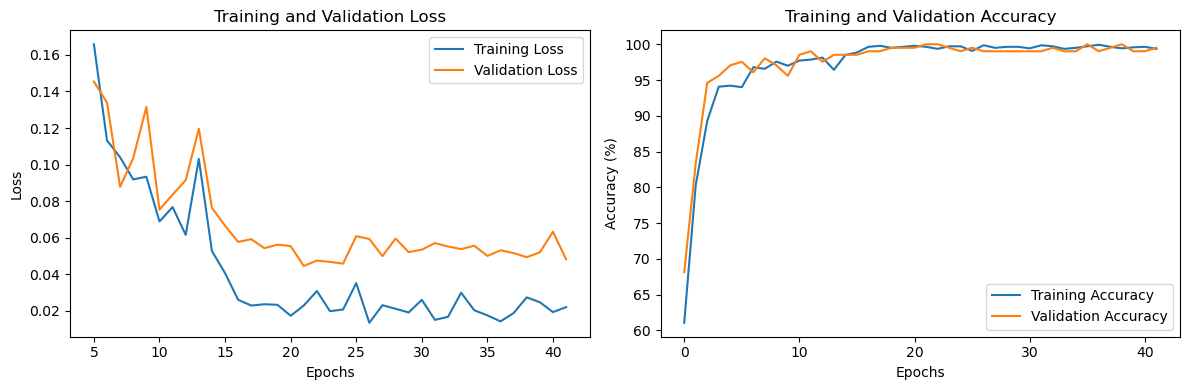

Accuracy of the network on the test set: 99.4949494949495 %


In [21]:
diagnostic_scores = []
diagnostic_validity = []
diagnostic_structure = []

quality_scores = []
quality_shapes = []
quality_trends = []

accuracies_all = []
accuracies_0 = []
accuracies_1 = []
accuracies_2 = []
accuracies_3 = []
accuracies_abn = []
for num_iter in range(10):
    print('##################################### Iteration ', num_iter+1, '#####################################')
    synthesizer = TVAESynthesizer(metadata)
    synthesizer.fit(feature_matrix_nona_nostr)
    
    synthetic_data = synthesizer.sample(num_rows=1000)
    
    diagnostic = run_diagnostic(
        real_data=feature_matrix_nona_nostr,
        synthetic_data=synthetic_data,
        metadata=metadata
    )
    
    quality_report = evaluate_quality(
        feature_matrix_nona_nostr,
        synthetic_data,
        metadata
    )
    
    diagnostic_scores.append(diagnostic.get_score())
    diagnostic_validity.append(diagnostic.get_properties().at[0, 'Score'])
    diagnostic_structure.append(diagnostic.get_properties().at[1, 'Score'])
    
    quality_scores.append(quality_report.get_score())
    quality_shapes.append(quality_report.get_properties().at[0, 'Score'])
    quality_trends.append(quality_report.get_properties().at[1, 'Score'])
    
    acc_all, acc_0, acc_1, acc_2, acc_3, acc_abn = run_discriminator_training(synthetic_data)
    accuracies_all.append(acc_all)
    accuracies_0.append(acc_0)
    accuracies_1.append(acc_1)
    accuracies_2.append(acc_2)
    accuracies_3.append(acc_3)
    accuracies_abn.append(acc_abn)

In [22]:
{'diagnostic_score':np.mean(diagnostic_scores), 'diagnostic_validity':np.mean(diagnostic_validity), 'diagnostic_structure':np.mean(diagnostic_structure), 'quality_score':np.mean(quality_scores), 'quality_shapes':np.mean(quality_shapes), 'quality_trends':np.mean(quality_trends)}

{'diagnostic_score': 1.0,
 'diagnostic_validity': 1.0,
 'diagnostic_structure': 1.0,
 'quality_score': 0.8384580302830245,
 'quality_shapes': 0.8351245939675174,
 'quality_trends': 0.8417914665985317}

In [23]:
{'accuracy_all_data':np.mean(accuracies_all), 'accuracy_normal_users':np.mean(accuracies_0), 'accuracy_abnormal_1':np.mean(accuracies_1), 'accuracy_abnormal_2':np.mean(accuracies_2), 'accuracy_abnormal_3':np.mean(accuracies_3), 'accuracy_all_abnormal_users':np.mean(accuracies_abn)}

{'accuracy_all_data': 99.36868686868686,
 'accuracy_normal_users': 99.39313287008747,
 'accuracy_abnormal_1': 97.14285714285714,
 'accuracy_abnormal_2': 100.0,
 'accuracy_abnormal_3': 100.0,
 'accuracy_all_abnormal_users': 98.8562091503268}

### 3. hybrid

##################################### Iteration  1 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)                                              11
NUM_UN

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 620.55it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:03<00:00, 110.38it/s]

Overall Score: 79.04%

Properties:
- Column Shapes: 74.33%
- Column Pair Trends: 83.76%
Epoch [1/10000], Avg. Training Loss: 0.6114689999006011, Training Accuracy: 67.57142857142857%, Avg. Validation Loss: 0.5426411880896642, Validation Accuracy: 84.80392156862744%
Epoch [2/10000], Avg. Training Loss: 0.3594829516316002, Training Accuracy: 89.42857142857143%, Avg. Validation Loss: 0.30348900533639467, Validation Accuracy: 96.56862745098039%
Epoch [3/10000], 

Epoch [47/10000], Avg. Training Loss: 0.0008900759603420738, Training Accuracy: 100.0%, Avg. Validation Loss: 0.002110591991088138, Validation Accuracy: 100.0%
Epoch [48/10000], Avg. Training Loss: 0.0013102652460061522, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0021484673399334918, Validation Accuracy: 100.0%
Epoch [49/10000], Avg. Training Loss: 0.0010633801628666167, Training Accuracy: 100.0%, Avg. Validation Loss: 0.00210996729751619, Validation Accuracy: 100.0%
Epoch [50/10000], Avg. Training Loss: 0.0012119877332720948, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0020539253556097928, Validation Accuracy: 100.0%
Epoch [51/10000], Avg. Training Loss: 0.0006425191993250999, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0016846797751406063, Validation Accuracy: 100.0%
Epoch [52/10000], Avg. Training Loss: 0.0007470846351431894, Training Accuracy: 100.0%, Avg. Validation Loss: 0.001826578527330779, Validation Accuracy: 100.0%
Epoch [53/10000], Avg. Training Loss: 

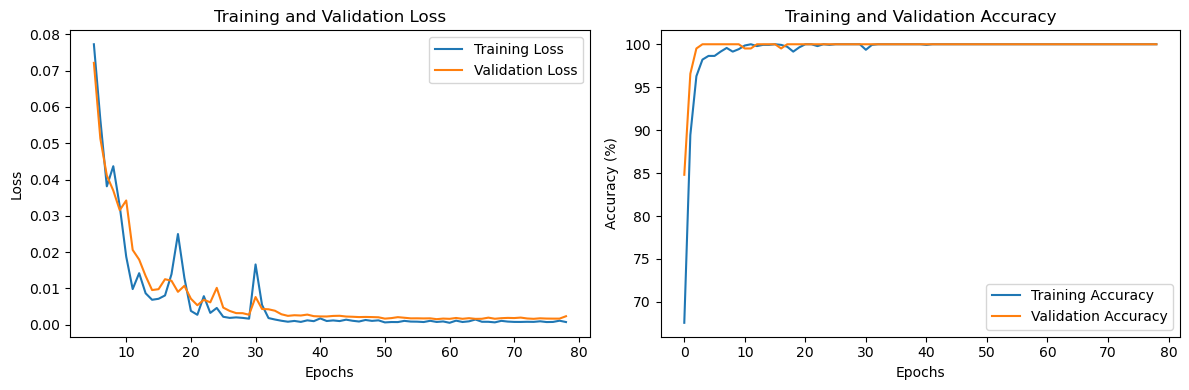

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  2 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)      

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 601.16it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:07<00:00, 109.84it/s]

Overall Score: 78.7%

Properties:
- Column Shapes: 73.98%
- Column Pair Trends: 83.43%
Epoch [1/10000], Avg. Training Loss: 0.5708152194592085, Training Accuracy: 71.57142857142857%, Avg. Validation Loss: 0.5196468256987058, Validation Accuracy: 75.98039215686275%
Epoch [2/10000], Avg. Training Loss: 0.3369609991257841, Training Accuracy: 90.42857142857143%, Avg. Validation Loss: 0.31325502349780154, Validation Accuracy: 95.09803921568627%
Epoch [3/10000], A

Epoch [46/10000], Avg. Training Loss: 0.0024623063853306867, Training Accuracy: 100.0%, Avg. Validation Loss: 0.008160320289719563, Validation Accuracy: 100.0%
Epoch [47/10000], Avg. Training Loss: 0.0032135804715587506, Training Accuracy: 100.0%, Avg. Validation Loss: 0.00941484564772019, Validation Accuracy: 100.0%
Epoch [48/10000], Avg. Training Loss: 0.003857685692227361, Training Accuracy: 100.0%, Avg. Validation Loss: 0.009803426559441365, Validation Accuracy: 100.0%
Epoch [49/10000], Avg. Training Loss: 0.0043024989903311835, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.00854175784983314, Validation Accuracy: 100.0%
Epoch [50/10000], Avg. Training Loss: 0.0040311489217194985, Training Accuracy: 100.0%, Avg. Validation Loss: 0.008868871865650782, Validation Accuracy: 100.0%
Epoch 00046: reducing learning rate of group 0 to 1.0000e-08.
Epoch [51/10000], Avg. Training Loss: 0.0035802436442199078, Training Accuracy: 100.0%, Avg. Validation Loss: 0.00937764969869301

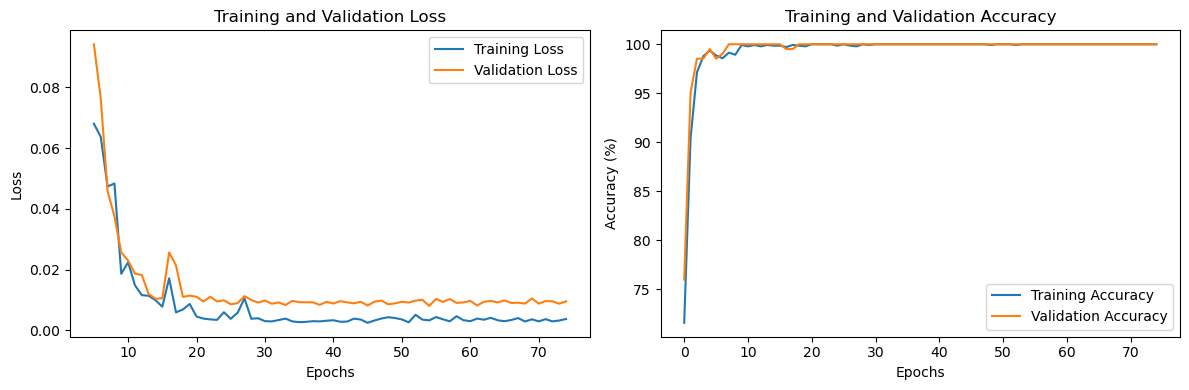

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  3 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)      

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 638.60it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:02<00:00, 110.50it/s]

Overall Score: 79.6%

Properties:
- Column Shapes: 74.93%
- Column Pair Trends: 84.27%
Epoch [1/10000], Avg. Training Loss: 0.5714242109520868, Training Accuracy: 70.0%, Avg. Validation Loss: 0.45722943315139186, Validation Accuracy: 79.41176470588235%
Epoch [2/10000], Avg. Training Loss: 0.29734126080504875, Training Accuracy: 89.14285714285714%, Avg. Validation Loss: 0.23383616025631243, Validation Accuracy: 95.58823529411765%
Epoch [3/10000], Avg. Trainin

Epoch [48/10000], Avg. Training Loss: 0.0008654176736771743, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0029524155677511143, Validation Accuracy: 100.0%
Epoch [49/10000], Avg. Training Loss: 0.0009043887534558467, Training Accuracy: 100.0%, Avg. Validation Loss: 0.003055780051419368, Validation Accuracy: 100.0%
Epoch [50/10000], Avg. Training Loss: 0.0007043990782139273, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0029282698300308906, Validation Accuracy: 100.0%
Epoch [51/10000], Avg. Training Loss: 0.0006130192687123781, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0025725824973331047, Validation Accuracy: 100.0%
Epoch 00047: reducing learning rate of group 0 to 1.0000e-06.
Epoch [52/10000], Avg. Training Loss: 0.0014683573253106178, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.0031210515970507492, Validation Accuracy: 100.0%
Epoch [53/10000], Avg. Training Loss: 0.0006222078309292556, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0026488313

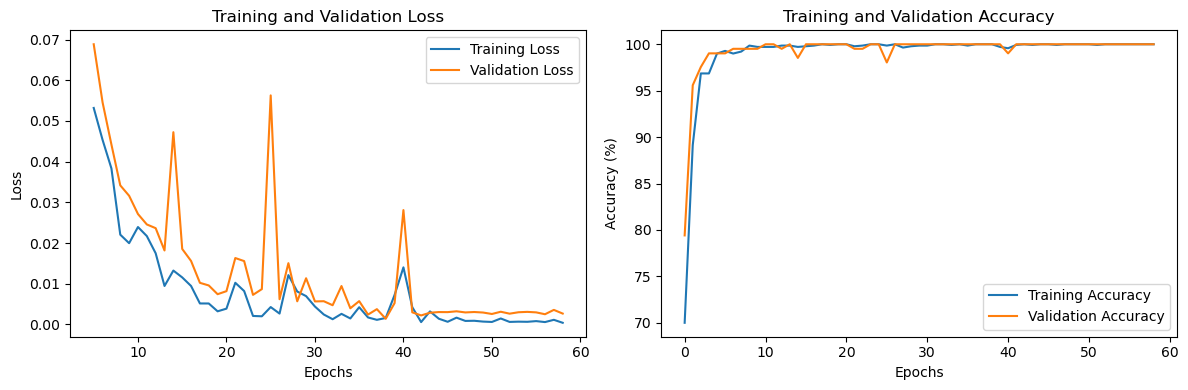

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  4 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)      

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 573.93it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:06<00:00, 110.02it/s]

Overall Score: 79.59%

Properties:
- Column Shapes: 74.97%
- Column Pair Trends: 84.21%
Epoch [1/10000], Avg. Training Loss: 0.5595828413285993, Training Accuracy: 72.21428571428571%, Avg. Validation Loss: 0.40875635468042815, Validation Accuracy: 91.17647058823529%
Epoch [2/10000], Avg. Training Loss: 0.2960510782220147, Training Accuracy: 93.85714285714286%, Avg. Validation Loss: 0.2721562970143098, Validation Accuracy: 97.05882352941177%
Epoch [3/10000], 

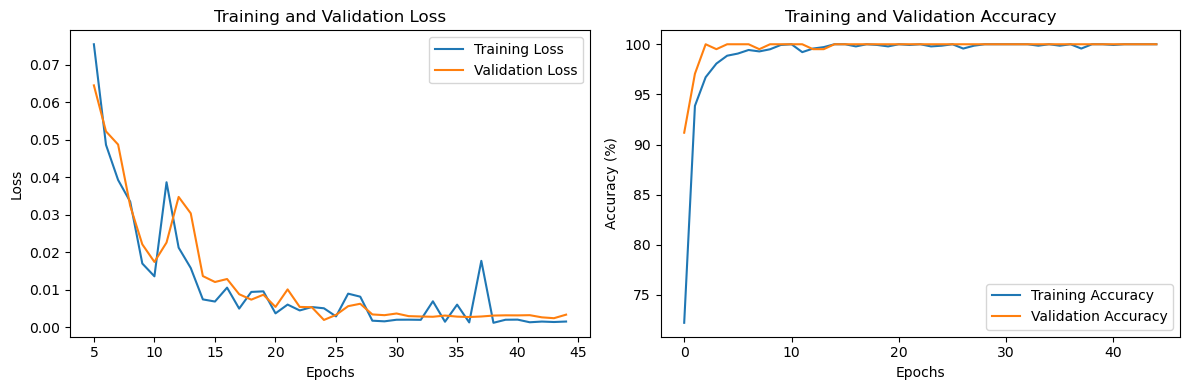

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  5 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)      

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 583.60it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [16:42<00:00, 92.82it/s]

Overall Score: 79.65%

Properties:
- Column Shapes: 75.01%
- Column Pair Trends: 84.3%
Epoch [1/10000], Avg. Training Loss: 0.6120350960303437, Training Accuracy: 65.78571428571429%, Avg. Validation Loss: 0.3797018069487352, Validation Accuracy: 91.66666666666667%
Epoch [2/10000], Avg. Training Loss: 0.32095412808385765, Training Accuracy: 89.64285714285714%, Avg. Validation Loss: 0.20374284799282366, Validation Accuracy: 98.52941176470588%
Epoch [3/10000], 

Epoch [47/10000], Avg. Training Loss: 0.036687971028765205, Training Accuracy: 99.42857142857143%, Avg. Validation Loss: 0.002517669810913503, Validation Accuracy: 100.0%
Epoch [48/10000], Avg. Training Loss: 0.0011162745401882355, Training Accuracy: 100.0%, Avg. Validation Loss: 0.002352527306916622, Validation Accuracy: 100.0%
Epoch [49/10000], Avg. Training Loss: 0.0009293211447088238, Training Accuracy: 100.0%, Avg. Validation Loss: 0.003461020335984918, Validation Accuracy: 100.0%
Epoch 00045: reducing learning rate of group 0 to 1.0000e-06.
Epoch [50/10000], Avg. Training Loss: 0.0006947147414228476, Training Accuracy: 100.0%, Avg. Validation Loss: 0.002193404728761659, Validation Accuracy: 100.0%
Epoch [51/10000], Avg. Training Loss: 0.0010672947835039602, Training Accuracy: 100.0%, Avg. Validation Loss: 0.0025394635651117335, Validation Accuracy: 100.0%
Epoch [52/10000], Avg. Training Loss: 0.0008523665498862763, Training Accuracy: 100.0%, Avg. Validation Loss: 0.00236553074612

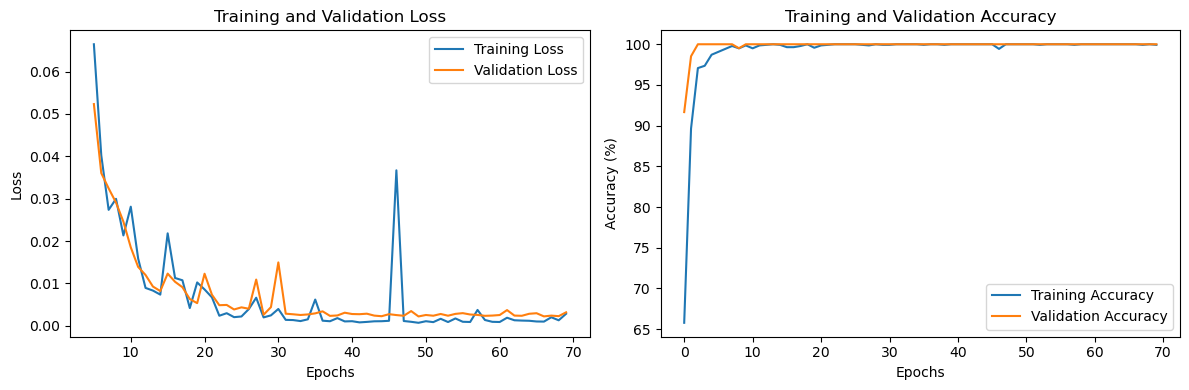

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  6 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)      

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 629.21it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [14:10<00:00, 109.48it/s]

Overall Score: 79.44%

Properties:
- Column Shapes: 75.12%
- Column Pair Trends: 83.76%
Epoch [1/10000], Avg. Training Loss: 0.5708352838727561, Training Accuracy: 71.28571428571429%, Avg. Validation Loss: 0.4681996382199801, Validation Accuracy: 78.92156862745098%
Epoch [2/10000], Avg. Training Loss: 0.334448006850752, Training Accuracy: 89.71428571428571%, Avg. Validation Loss: 0.268189570078483, Validation Accuracy: 94.11764705882354%
Epoch [3/10000], Avg

Epoch [46/10000], Avg. Training Loss: 0.002323530092491472, Training Accuracy: 100.0%, Avg. Validation Loss: 0.005697850299139435, Validation Accuracy: 100.0%
Early stopping due to no improvement in validation loss.


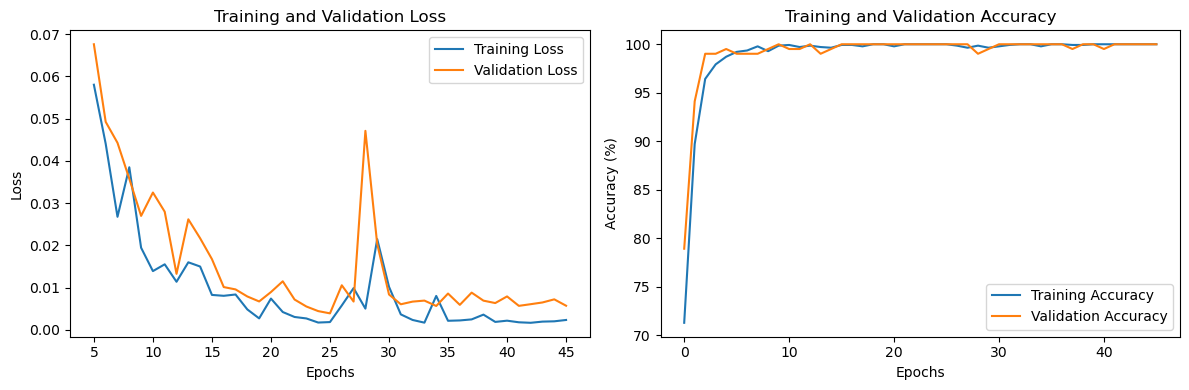

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  7 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)      

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 481.50it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [15:12<00:00, 102.06it/s]

Overall Score: 80.25%

Properties:
- Column Shapes: 76.52%
- Column Pair Trends: 83.98%
Epoch [1/10000], Avg. Training Loss: 0.6015108667991378, Training Accuracy: 69.07142857142857%, Avg. Validation Loss: 0.529847658597506, Validation Accuracy: 88.23529411764706%
Epoch [2/10000], Avg. Training Loss: 0.38350520824844186, Training Accuracy: 87.85714285714286%, Avg. Validation Loss: 0.3102052154449316, Validation Accuracy: 97.05882352941177%
Epoch [3/10000], A

Epoch [46/10000], Avg. Training Loss: 0.004337619749342345, Training Accuracy: 100.0%, Avg. Validation Loss: 0.011434696113260893, Validation Accuracy: 100.0%
Epoch [47/10000], Avg. Training Loss: 0.004755422509995035, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.011122058432262678, Validation Accuracy: 100.0%
Epoch [48/10000], Avg. Training Loss: 0.0036223418335959486, Training Accuracy: 100.0%, Avg. Validation Loss: 0.010921091127854127, Validation Accuracy: 100.0%
Epoch [49/10000], Avg. Training Loss: 0.004143447812318548, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.011947793456224294, Validation Accuracy: 100.0%
Epoch [50/10000], Avg. Training Loss: 0.004191435074476017, Training Accuracy: 100.0%, Avg. Validation Loss: 0.011533166281878948, Validation Accuracy: 100.0%
Epoch [51/10000], Avg. Training Loss: 0.004468236027274874, Training Accuracy: 100.0%, Avg. Validation Loss: 0.011643937430702724, Validation Accuracy: 100.0%
Epoch [52/10000], Avg

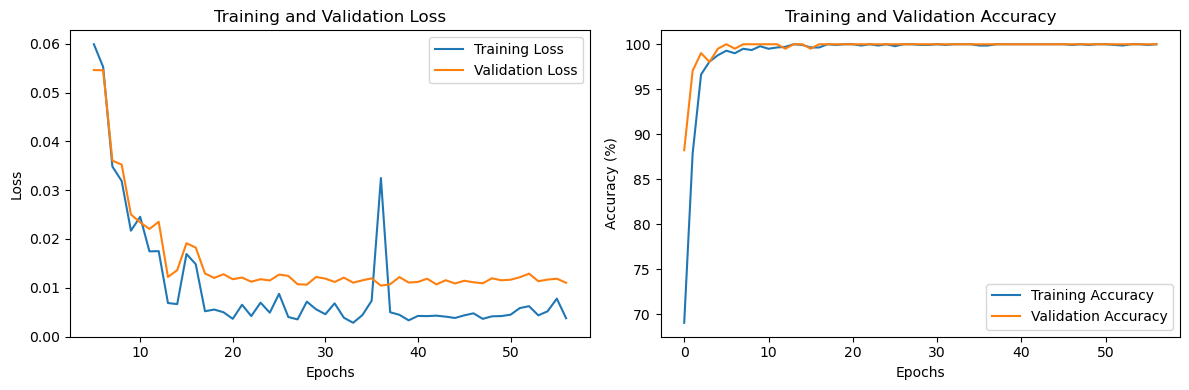

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  8 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)      

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 538.01it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [15:00<00:00, 103.37it/s]

Overall Score: 78.6%

Properties:
- Column Shapes: 73.63%
- Column Pair Trends: 83.56%
Epoch [1/10000], Avg. Training Loss: 0.5494313615966927, Training Accuracy: 72.14285714285714%, Avg. Validation Loss: 0.4111251922754141, Validation Accuracy: 90.19607843137256%
Epoch [2/10000], Avg. Training Loss: 0.3063740058040077, Training Accuracy: 93.14285714285714%, Avg. Validation Loss: 0.26123316012896025, Validation Accuracy: 97.05882352941177%
Epoch [3/10000], A

Epoch [46/10000], Avg. Training Loss: 0.0017388876384013036, Training Accuracy: 100.0%, Avg. Validation Loss: 0.004414216006317964, Validation Accuracy: 100.0%
Epoch [47/10000], Avg. Training Loss: 0.005110471472025066, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.004316766423961291, Validation Accuracy: 100.0%
Epoch 00043: reducing learning rate of group 0 to 1.0000e-07.
Epoch [48/10000], Avg. Training Loss: 0.0016690288618767888, Training Accuracy: 100.0%, Avg. Validation Loss: 0.004139795809840927, Validation Accuracy: 100.0%
Epoch [49/10000], Avg. Training Loss: 0.0016100974039132284, Training Accuracy: 100.0%, Avg. Validation Loss: 0.00416869199118362, Validation Accuracy: 100.0%
Epoch [50/10000], Avg. Training Loss: 0.0017105693362034137, Training Accuracy: 100.0%, Avg. Validation Loss: 0.00459655958156173, Validation Accuracy: 100.0%
Epoch [51/10000], Avg. Training Loss: 0.004282095835151267, Training Accuracy: 99.85714285714286%, Avg. Validation Loss: 0.004477

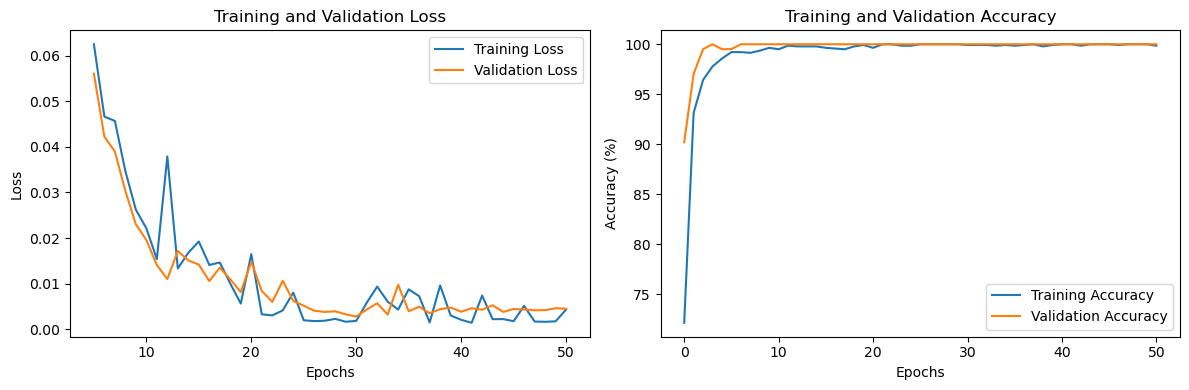

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  9 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)      

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 619.27it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [15:16<00:00, 101.56it/s]

Overall Score: 79.92%

Properties:
- Column Shapes: 75.34%
- Column Pair Trends: 84.51%
Epoch [1/10000], Avg. Training Loss: 0.5574821000072089, Training Accuracy: 71.28571428571429%, Avg. Validation Loss: 0.3814949691295624, Validation Accuracy: 90.19607843137256%
Epoch [2/10000], Avg. Training Loss: 0.3060375629839572, Training Accuracy: 91.71428571428571%, Avg. Validation Loss: 0.24409425258636475, Validation Accuracy: 98.03921568627452%
Epoch [3/10000], 

Epoch [46/10000], Avg. Training Loss: 0.0027955617518852127, Training Accuracy: 99.92857142857143%, Avg. Validation Loss: 0.0060725606297357725, Validation Accuracy: 100.0%
Epoch [47/10000], Avg. Training Loss: 0.002301833897945471, Training Accuracy: 100.0%, Avg. Validation Loss: 0.005601478471922187, Validation Accuracy: 100.0%
Early stopping due to no improvement in validation loss.


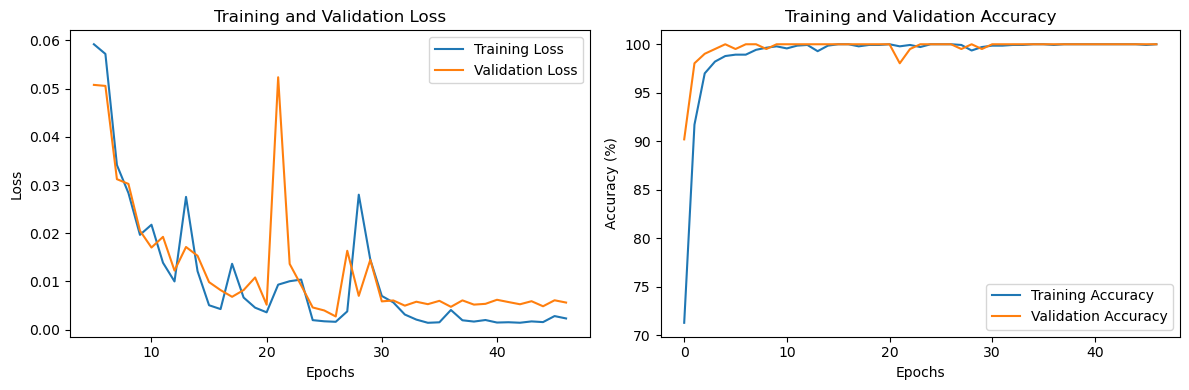

Accuracy of the network on the test set: 100.0 %
##################################### Iteration  10 #####################################
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name                                            Est # of Columns (CTGAN)
O                                                               11
C                                                               11
E                                                               11
A                                                               11
N                                                               11
AVERAGE_COUNT_PER_UNIQUE(logons.activity)                       11
AVERAGE_COUNT_PER_UNIQUE(logons.pc)                             11
COUNT(logons)                                                   11
ENTROPY(logons.activity)                                        11
ENTROPY(logons.pc)     

Generating report ...
(2/2) Evaluating Data Structure: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 639.67it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93096/93096 [16:15<00:00, 95.48it/s]

Overall Score: 79.51%

Properties:
- Column Shapes: 75.28%
- Column Pair Trends: 83.74%
Epoch [1/10000], Avg. Training Loss: 0.4908550215715712, Training Accuracy: 77.57142857142857%, Avg. Validation Loss: 0.34700990410951466, Validation Accuracy: 91.17647058823529%
Epoch [2/10000], Avg. Training Loss: 0.2852141103622588, Training Accuracy: 93.85714285714286%, Avg. Validation Loss: 0.2411752354640227, Validation Accuracy: 98.03921568627452%
Epoch [3/10000], 

Epoch [46/10000], Avg. Training Loss: 0.0012973916519430613, Training Accuracy: 100.0%, Avg. Validation Loss: 0.004539010168697972, Validation Accuracy: 100.0%
Epoch [47/10000], Avg. Training Loss: 0.0015760093053607059, Training Accuracy: 100.0%, Avg. Validation Loss: 0.004762657935946033, Validation Accuracy: 100.0%
Epoch [48/10000], Avg. Training Loss: 0.0011538643218293807, Training Accuracy: 100.0%, Avg. Validation Loss: 0.005684818965024673, Validation Accuracy: 100.0%
Early stopping due to no improvement in validation loss.


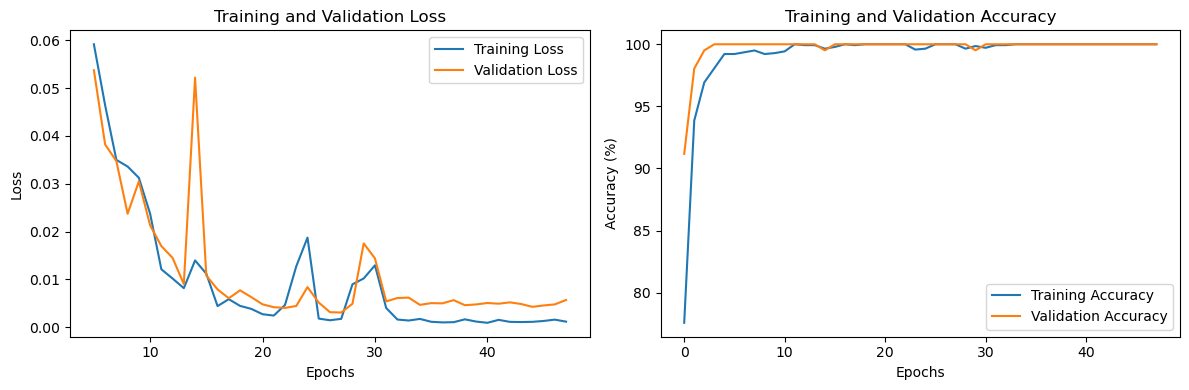

Accuracy of the network on the test set: 100.0 %


In [24]:
diagnostic_scores = []
diagnostic_validity = []
diagnostic_structure = []

quality_scores = []
quality_shapes = []
quality_trends = []

accuracies_all = []
accuracies_0 = []
accuracies_1 = []
accuracies_2 = []
accuracies_3 = []
accuracies_abn = []
for num_iter in range(10):
    print('##################################### Iteration ', num_iter+1, '#####################################')
    synthesizer = CopulaGANSynthesizer(metadata)
    synthesizer.fit(feature_matrix_nona_nostr)
    
    synthetic_data = synthesizer.sample(num_rows=1000)
    
    diagnostic = run_diagnostic(
        real_data=feature_matrix_nona_nostr,
        synthetic_data=synthetic_data,
        metadata=metadata
    )
    
    quality_report = evaluate_quality(
        feature_matrix_nona_nostr,
        synthetic_data,
        metadata
    )
    
    diagnostic_scores.append(diagnostic.get_score())
    diagnostic_validity.append(diagnostic.get_properties().at[0, 'Score'])
    diagnostic_structure.append(diagnostic.get_properties().at[1, 'Score'])
    
    quality_scores.append(quality_report.get_score())
    quality_shapes.append(quality_report.get_properties().at[0, 'Score'])
    quality_trends.append(quality_report.get_properties().at[1, 'Score'])
    
    acc_all, acc_0, acc_1, acc_2, acc_3, acc_abn = run_discriminator_training(synthetic_data)
    accuracies_all.append(acc_all)
    accuracies_0.append(acc_0)
    accuracies_1.append(acc_1)
    accuracies_2.append(acc_2)
    accuracies_3.append(acc_3)
    accuracies_abn.append(acc_abn)

In [25]:
{'diagnostic_score':np.mean(diagnostic_scores), 'diagnostic_validity':np.mean(diagnostic_validity), 'diagnostic_structure':np.mean(diagnostic_structure), 'quality_score':np.mean(quality_scores), 'quality_shapes':np.mean(quality_shapes), 'quality_trends':np.mean(quality_trends)}

{'diagnostic_score': 1.0,
 'diagnostic_validity': 1.0,
 'diagnostic_structure': 1.0,
 'quality_score': 0.79431245373288,
 'quality_shapes': 0.7491034802784222,
 'quality_trends': 0.8395214271873377}

In [26]:
{'accuracy_all_data':np.mean(accuracies_all), 'accuracy_normal_users':np.mean(accuracies_0), 'accuracy_abnormal_1':np.mean(accuracies_1), 'accuracy_abnormal_2':np.mean(accuracies_2), 'accuracy_abnormal_3':np.mean(accuracies_3), 'accuracy_all_abnormal_users':np.mean(accuracies_abn)}

{'accuracy_all_data': 100.0,
 'accuracy_normal_users': 100.0,
 'accuracy_abnormal_1': 100.0,
 'accuracy_abnormal_2': 100.0,
 'accuracy_abnormal_3': 100.0,
 'accuracy_all_abnormal_users': 100.0}